In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import sys
sys.path.insert(1,'/u/nlp/packages/anaconda2/lib/python2.7/site-packages/')
import pandas as pd

from experiments.credit_assignment import *
from datasets.mnli import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import collections
import re
from matplotlib import colors as mcolors
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

import IPython

sns.set()

/u/nlp/packages/anaconda2/lib/python2.7/site-packages/pandas/__init__.py:25: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas import hashtable, tslib, lib
/u/nlp/packages/anaconda2/lib/python2.7/site-packages/pandas/__init__.py:25: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from pandas import hashtable, tslib, lib
/u/nlp/packages/anaconda2/lib/python2.7/site-packages/pandas/types/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas import lib, algos
/u/nlp/packages/anaconda2/lib/python2.7/site-packages/pandas/types/common.py:6: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from pandas import lib, algos
/u/nlp/packages/anaconda2/lib/python2.7/site-packages/pandas/indexes/base.py:8: RuntimeWarning: numpy.dtype size changed, may indicate b

/u/nlp/packages/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 80
  from . import _hashing
/u/nlp/packages/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:9: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 144
  from . import _hashing
/u/nlp/packages/anaconda2/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 80
  from ._logistic_sigmoid import _log_logistic_sigmoid
/u/nlp/packages/anaconda2/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 144
  from ._logistic_sigmoid import _log_logistic_sigmoid
/u/nlp/packages/anaconda2/lib/python2.7/site-packages/sklearn/utils/extmath.py:26: R

In [2]:
def load_data(exp_num):
    exp_ids = ['mnli_2_tf_training-False_sample_weights-False_batch_size-_initial_learning_rate-',
              ]
    exp_id = exp_ids[exp_num]
    print('Experiment {}'.format(exp_id))
    exp = CreditAssignment.load_run(exp_id, out_dir='/u/nlp/influence/output/')
    return exp_id, exp

def normalize(data):
    return np.array([data[i]/subset_sizes[i] for i in range(num_groups)])*max(subset_sizes)

def percent_pos(dataset):
    return sum(dataset.labels == 1)/len(dataset.labels)
    
def calcR(x, y):
    return pearsonr(x, y)[0]
    
def printR(x, y, x_lab, y_lab):
    print('Pearson\'s R between {} and {} is {}'.format(x_lab, y_lab, calcR(x,y)))

def line():
    print('-----------------------------')
    
def stem(ax, y, posInds, negInds, y_lab, title=None):
    n = len(y)
    ax.stem(np.array(range(n))[posInds]+1, y[posInds], label='pos', linefmt='b', markerfmt='bo')
    ax.stem(np.array(range(n))[negInds]+1, y[negInds], label='neg', linefmt='g', markerfmt='go')
    ax.set_xlabel('Turker id')
    ax.set_ylabel(y_lab)
    if title is not None:
        ax.set_title(title)
    ax.legend()

def hist(ax, x, x_lab, bins=10, title=None):
    ax.hist(x, bins=bins)
    ax.set_xlabel(x_lab)
    ax.set_ylabel('Frequency')
    if title is not None:
        ax.set_title('Group influence on set of nonfires\n{}'.format(ds_name))

    
def scatter(ax, x, y, x_lab, y_lab, title=None):
    ax.scatter(x, y)
    ax.set_xlabel(x_lab)
    ax.set_ylabel(y_lab)
    ax.legend()
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(pearsonr(x,y)[0])

In [5]:
exp_id, exp = load_data(0)
ds_name = exp.config['dataset_config']['dataset_id']
num_groups = len(exp.R['subset_tags'])

subset_tags, subset_indices = exp.R['subset_tags'], exp.R['subset_indices']
fixed_test, fixed_nonfires = exp.R['fixed_test'], exp.R['fixed_nonfires']
test_genres, nonfires_genres = exp.R['test_genres'], exp.R['nonfires_genres']

subset_sizes = np.array([len(a) for a in exp.R['subset_indices']])
difficulties = np.zeros(num_groups)
for i, indices in enumerate(subset_indices):
    difficulties[i] = np.mean(exp.R['initial_train_losses'][indices])
# Linguistic features TODO
metas = [subset_sizes, difficulties]
meta_names = ['Size', 'Difficulty']

from datasets.mnli import load_mnli_genres
train_genres = load_mnli_genres('/u/nlp/influence/data/')[0]
gens, inverse = np.unique(train_genres, return_inverse=True)
print('Contribution genres: {}'.format(gens))
genre_contribs = np.zeros((num_groups, 5), dtype=int)
for i in range(num_groups):
    for j in subset_indices[i]:
        genre_contribs[i][inverse[j]] += 1
genre_contribs = np.array(genre_contribs)
        
# yields x2
infl_names = ['_pred_infl', '_actl_infl']

# yields 1
self_prefix = ['self']

# yields 3x4
ds_names = ['train', 'test', 'nonfires']
scopes = ['all', 'class_0', 'class_1', 'class_2']
scoped_prefixes = ['{}_{}'.format(scope, ds_name) for scope in scopes for ds_name in ds_names]

# 5
test_gen_prefixes = ['{}_test'.format(gen) for gen in test_genres]
# 5
nonf_gen_prefixes = ['{}_nonfires'.format(gen) for gen in nonfires_genres]

# 2 x (hides 6)
fixed_prefixes = ['fixed_{}'.format(ds_name) for ds_name in ds_names[1:]]

all_prefixes = []
all_prefixes += self_prefix
all_prefixes += scoped_prefixes
all_prefixes += test_gen_prefixes + nonf_gen_prefixes # + fixed_prefixes
num_prefixes = len(all_prefixes)

# mask for anomalous turker + genres
mask = range(num_groups-5)

Experiment mnli_2_tf_training-False_sample_weights-False_batch_size-_initial_learning_rate-
Loading mnli from /u/nlp/influence/data/multinli_1.0/mnli.npz.
Loaded mnli.
Shape of training set: (392702, 600)
Loading nonfires from /u/nlp/influence/data/multinli_1.0/mnli_nonfires.npz.
Loaded mnli nonfires.
Dataset train:
Class 0 is 0.333329089233 of the dataset.
Class 1 is 0.333331635693 of the dataset.
Class 2 is 0.333339275074 of the dataset.
Dataset test:
Class 0 is 0.354457463067 of the dataset.
Class 1 is 0.318186449312 of the dataset.
Class 2 is 0.327356087621 of the dataset.
Dataset nonfires:
Class 0 is 0.352217249797 of the dataset.
Class 1 is 0.318246541904 of the dataset.
Class 2 is 0.329536208299 of the dataset.
Loading phase 1-initial_training from previous run:
/u/nlp/influence/output/credit_assignment/mnli_2_tf_training-False_sample_weights-False_batch_size-_initial_learning_rate-/result_1-initial_training.npz
Loading phase 2-pick_test_points from previous run:
/u/nlp/influenc

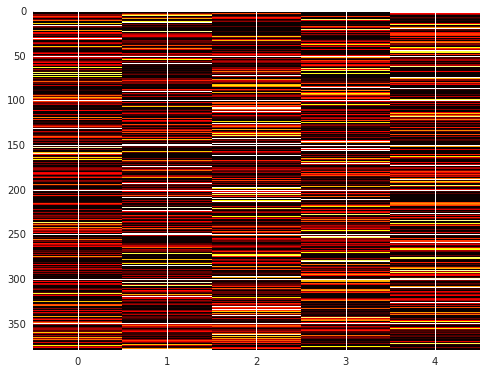

In [28]:
genre_contribs[:-5]
avg = [row/np.sum(row) for row in genre_contribs[:-5]]
fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
ax[0][0].imshow(avg, cmap='hot', interpolation='nearest', aspect=1e-2)
plt.show()

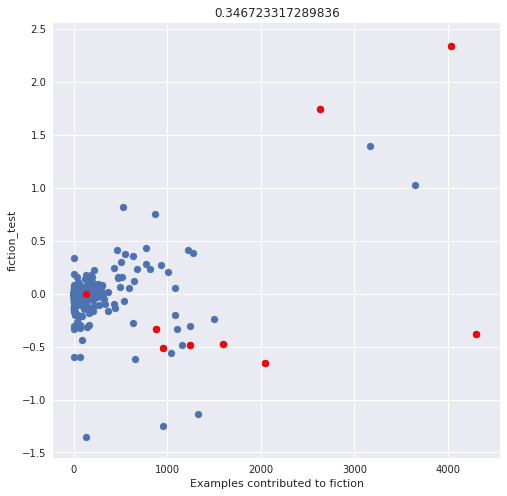

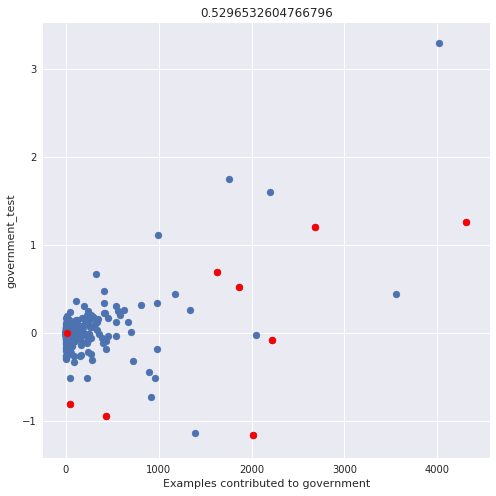

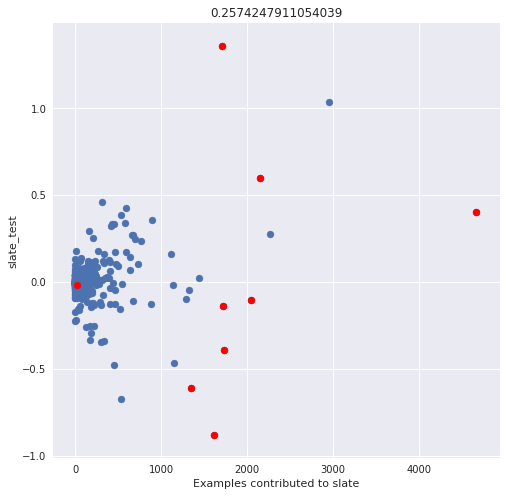

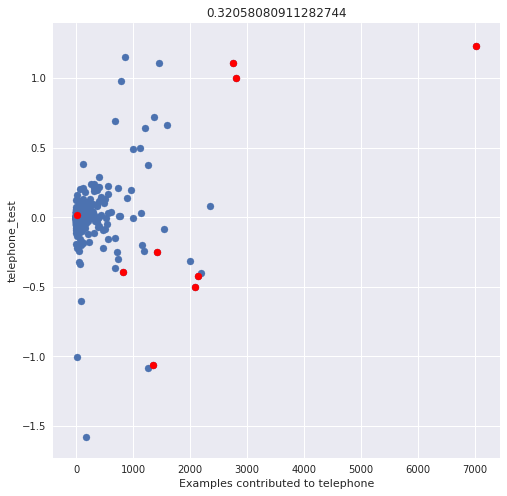

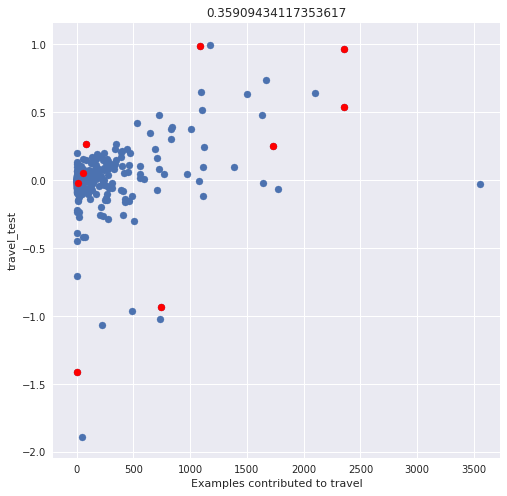

In [38]:
genre_contribs = np.array(genre_contribs)
prolific = np.argsort(np.sum(genre_contribs[:-5], axis=1))[-10:-1]
for i, prefix in enumerate(test_gen_prefixes):
    fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
    scatter(ax[0][0], genre_contribs[mask,i], exp.R[prefix+infl_names[0]][mask],\
            'Examples contributed to {}'.format(gens[i]), prefix)
    ax[0][0].scatter(genre_contribs[mask,i][prolific], exp.R[prefix+infl_names[0]][mask][prolific],c='r')

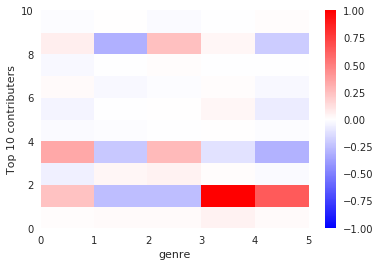

In [59]:
prolific = np.argsort(np.sum(genre_contribs[:-5], axis=1))[-10:]
prolific_infls_on_test_genres = np.zeros((10, 5), dtype=np.float32)
for i, turker in enumerate(prolific):
    for j, prefix in enumerate(test_gen_prefixes):
        prolific_infls_on_test_genres[i, j] = exp.R[prefix+infl_names[0]][i]
plt.set_cmap('bwr')
plt.pcolor(prolific_infls_on_test_genres, vmin=-1., vmax=1.)
plt.xlabel('genre')
plt.ylabel('Top 10 contributers')
plt.colorbar()
plt.show()

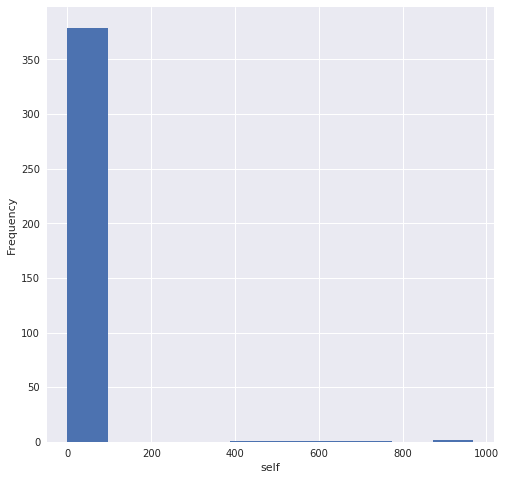

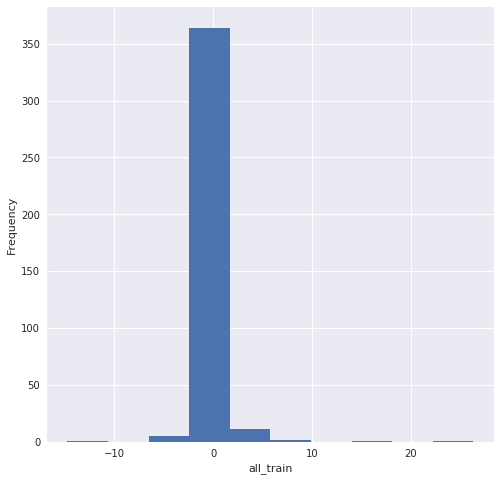

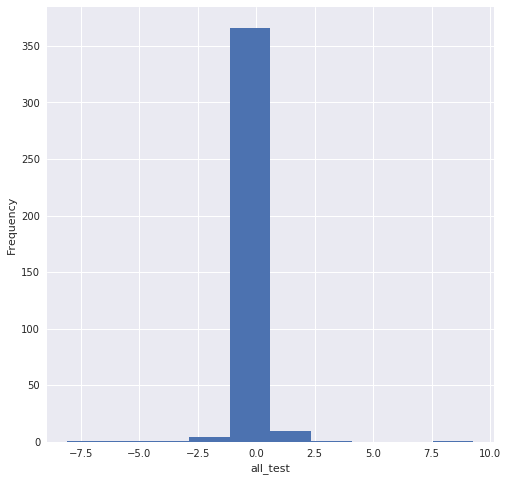

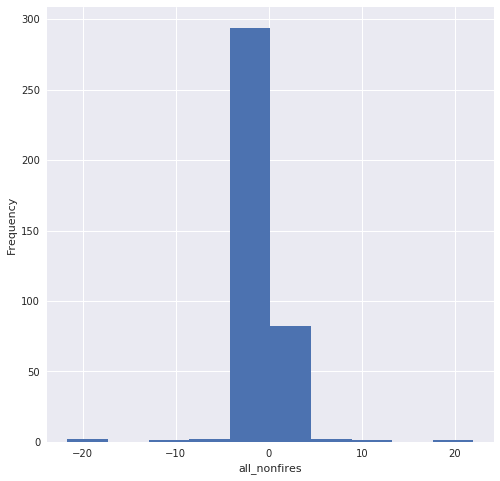

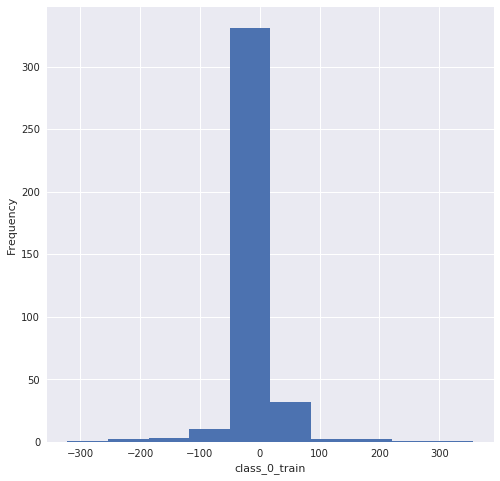

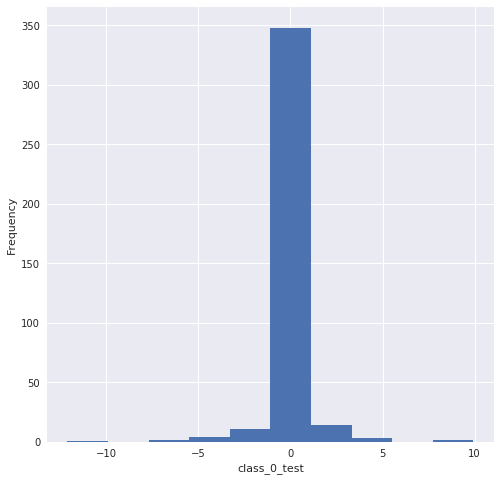

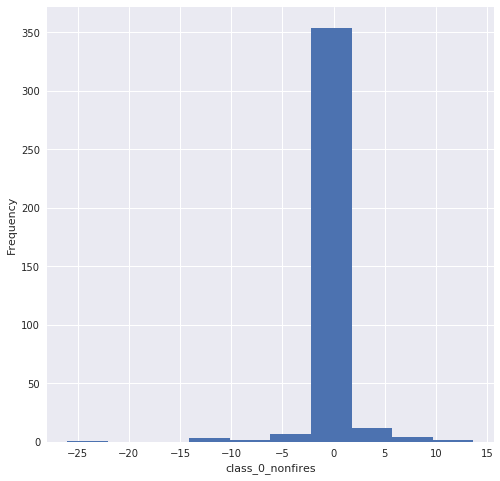

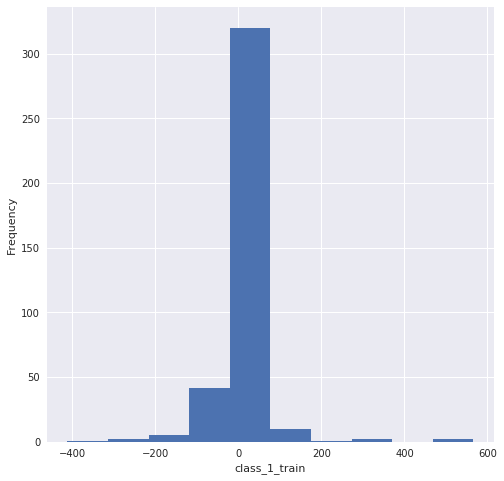

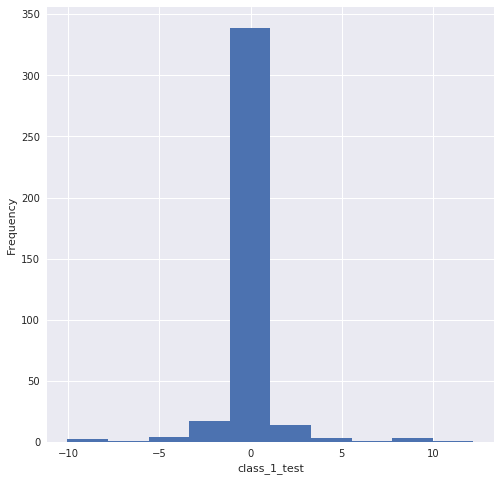

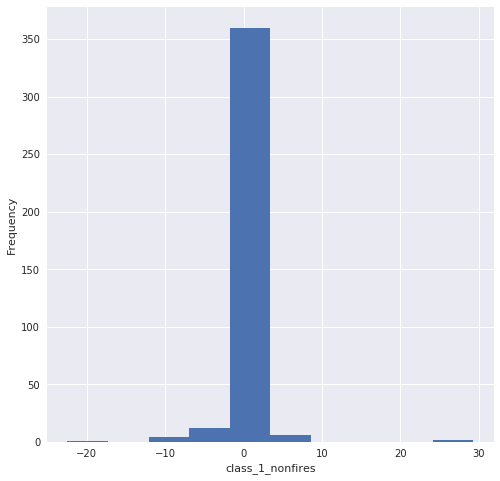

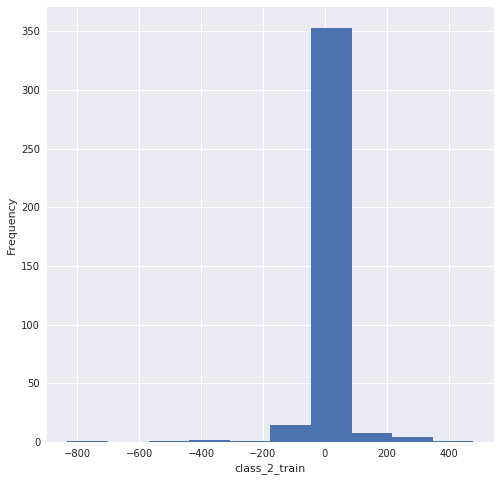

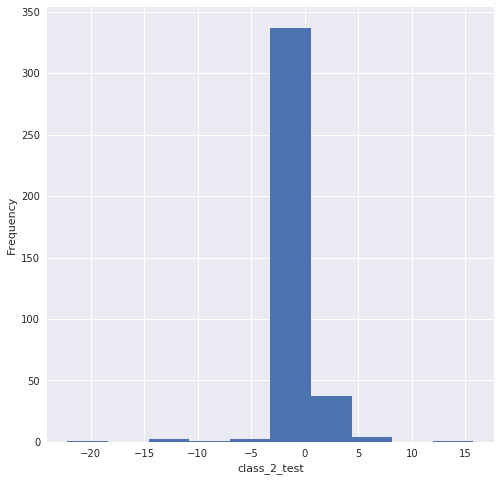

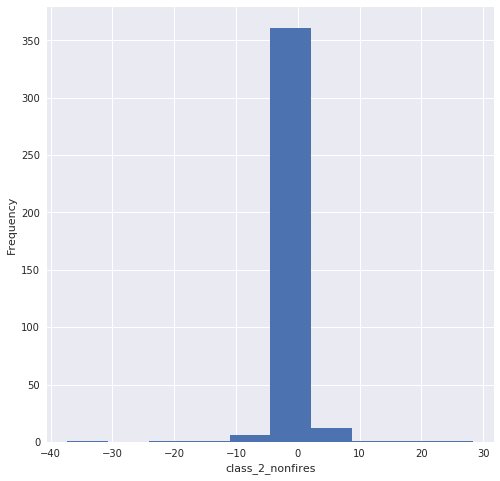

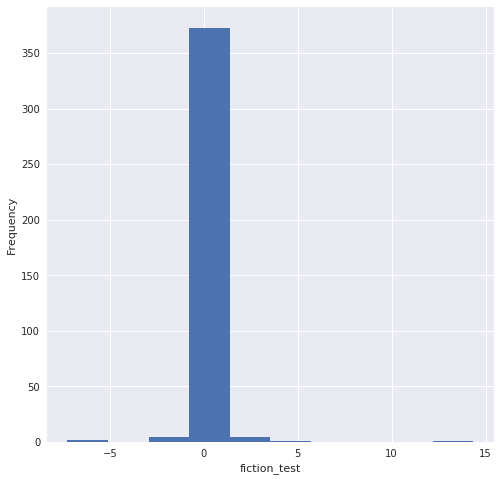

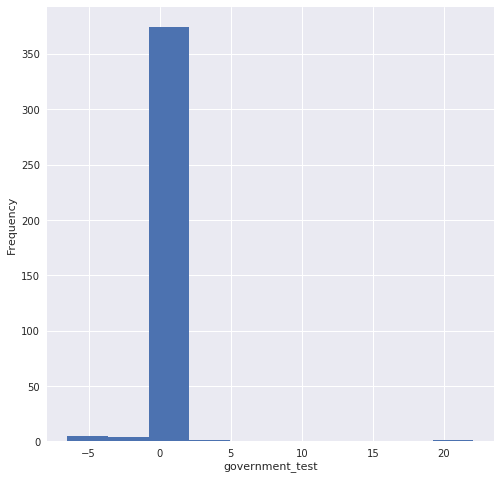

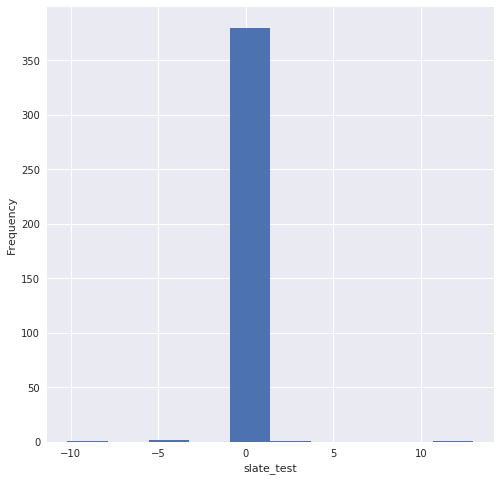

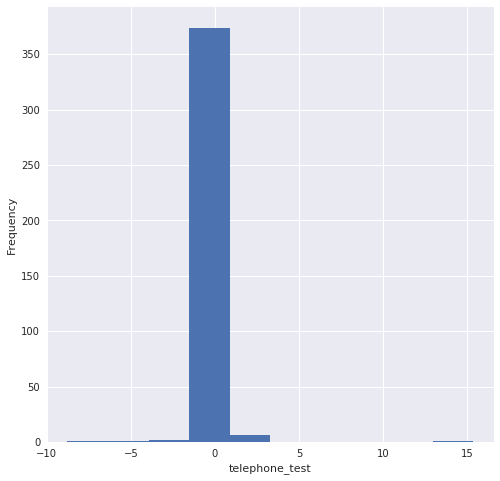

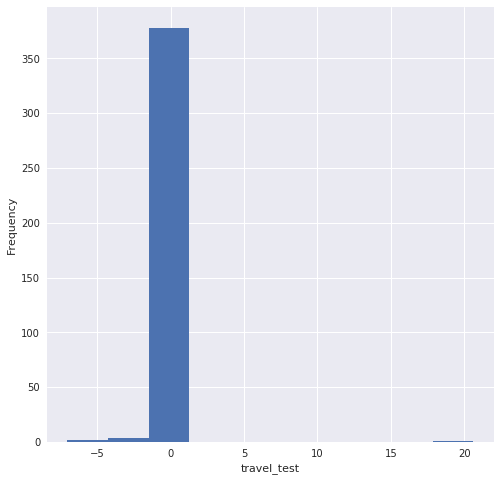

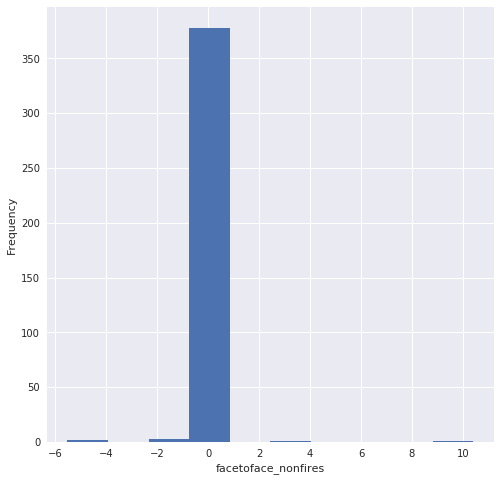

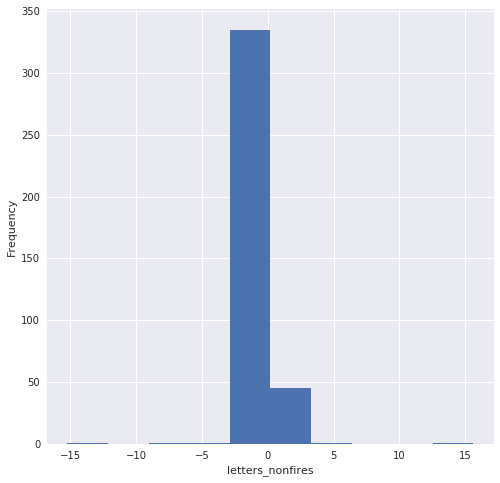

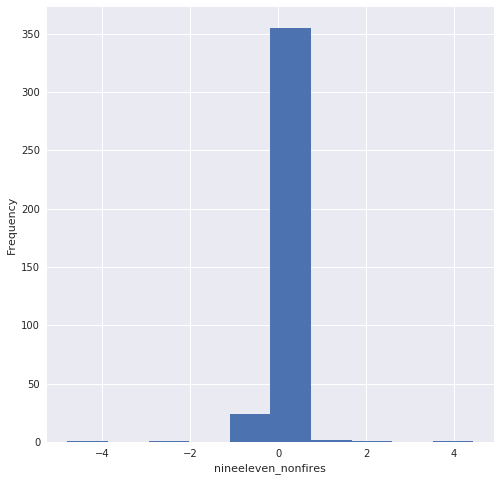

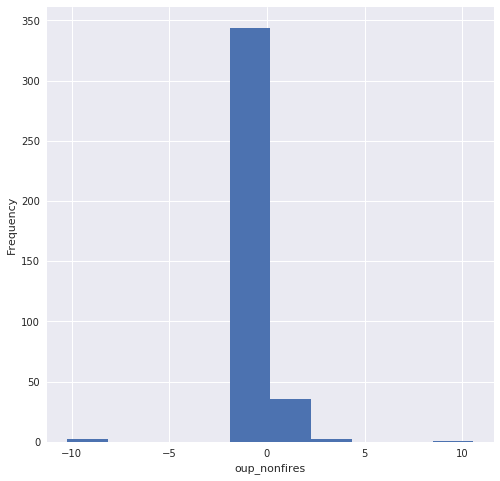

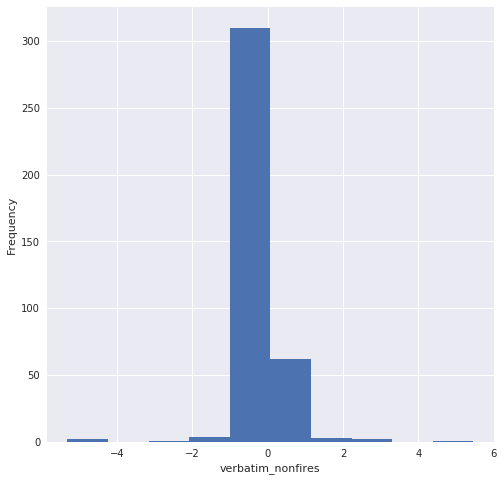

In [16]:
for prefix in all_prefixes:
    fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
    hist(ax[0][0], exp.R[prefix + infl_names[0]], prefix, bins=10)

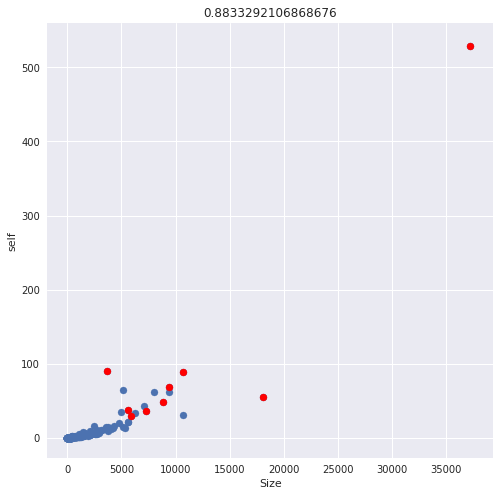

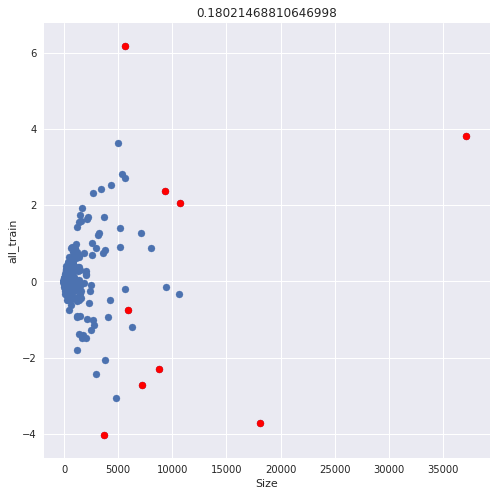

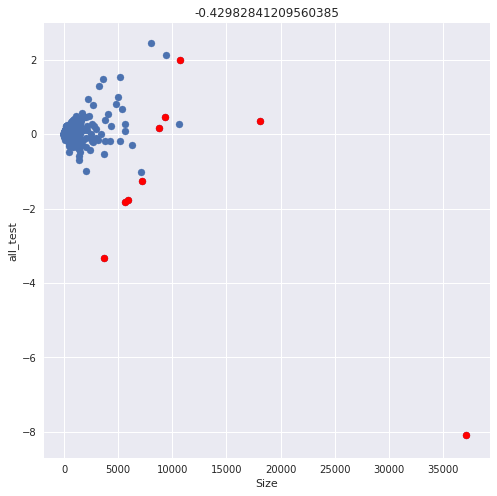

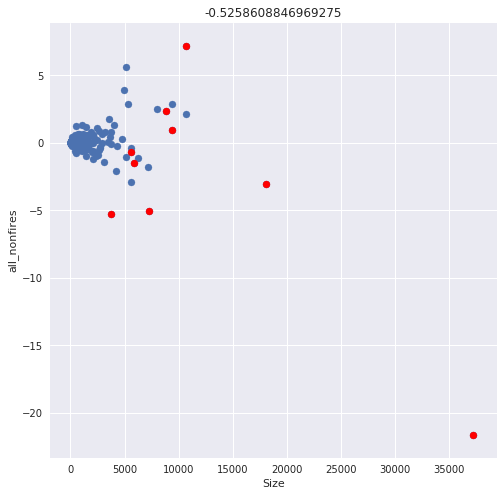

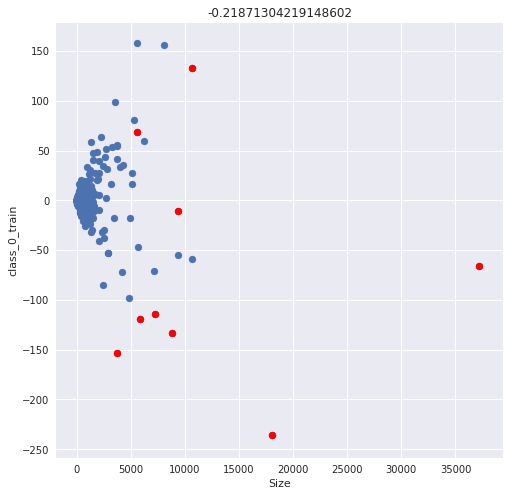

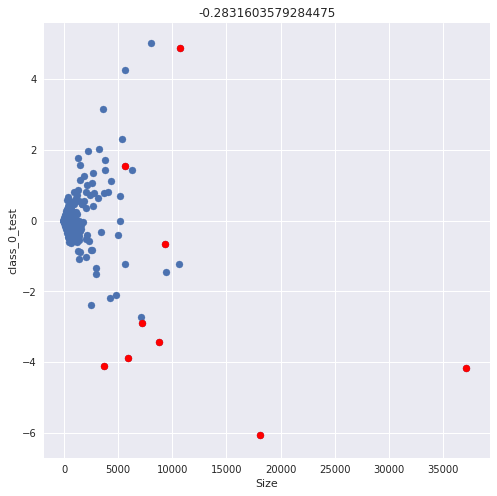

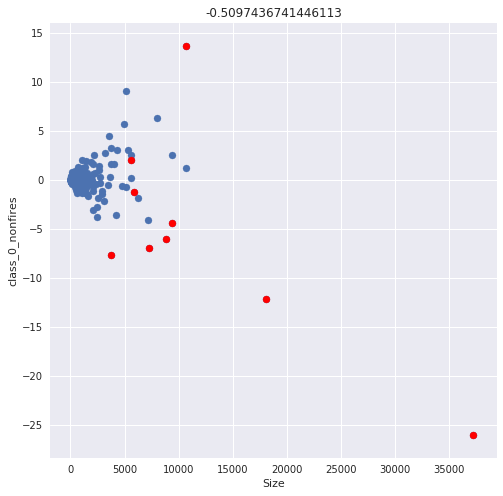

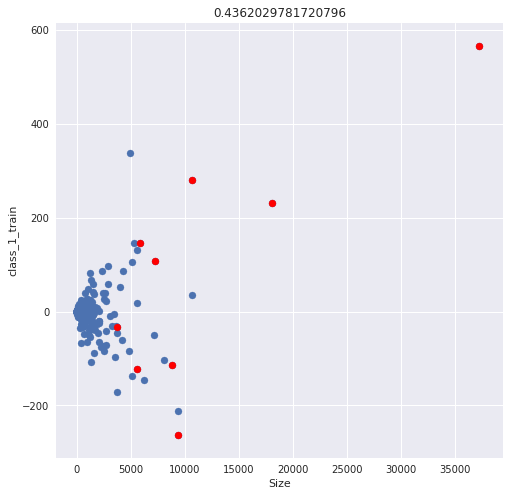

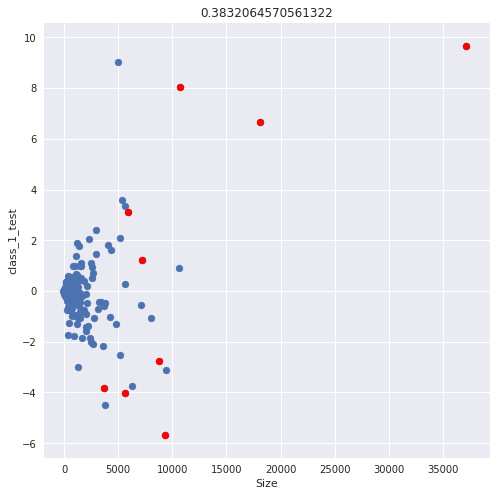

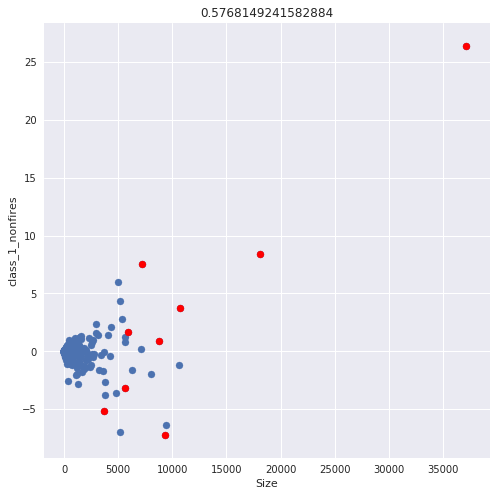

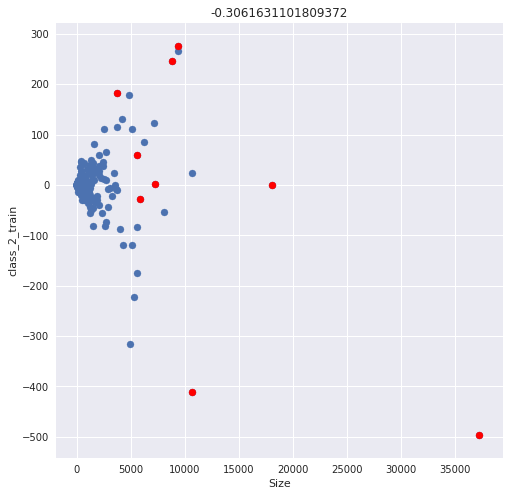

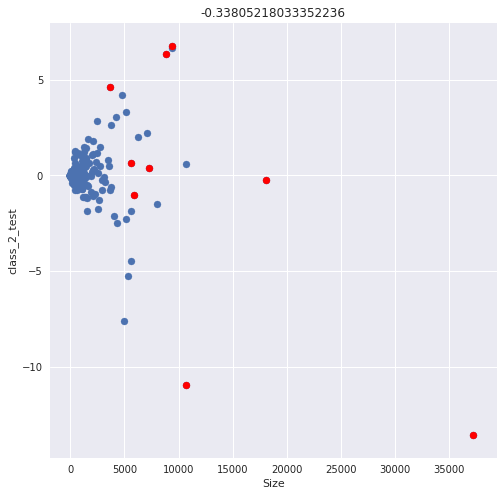

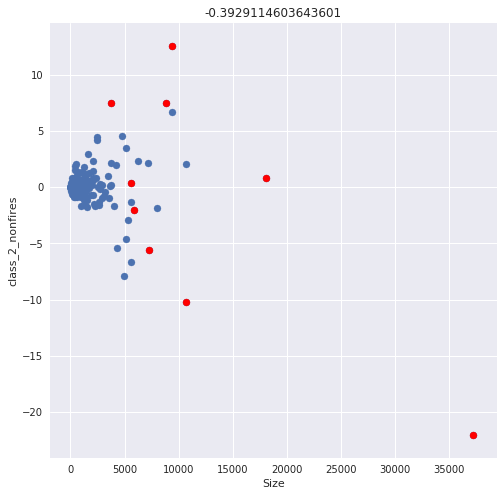

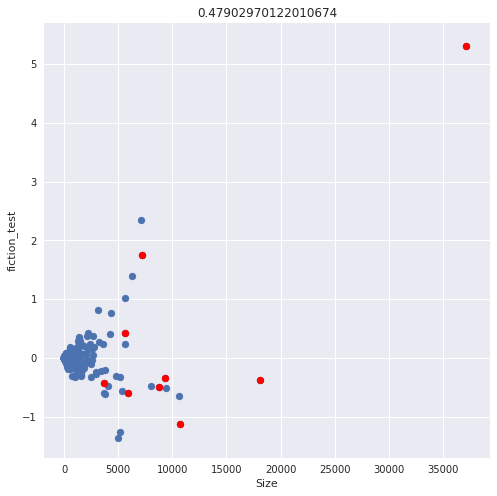

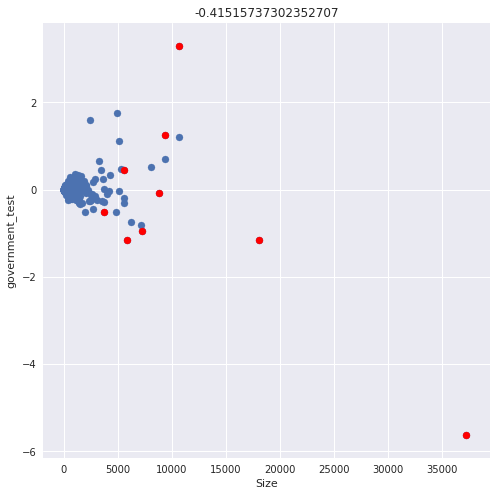

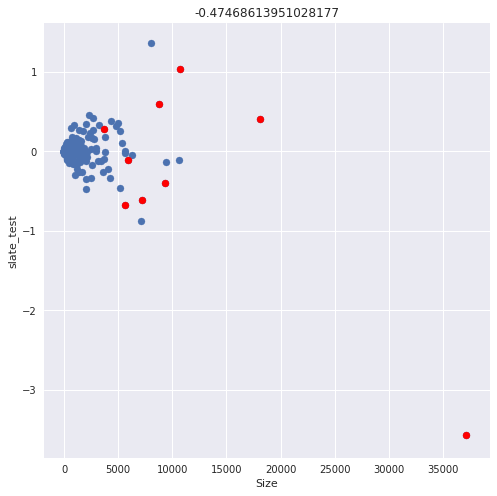

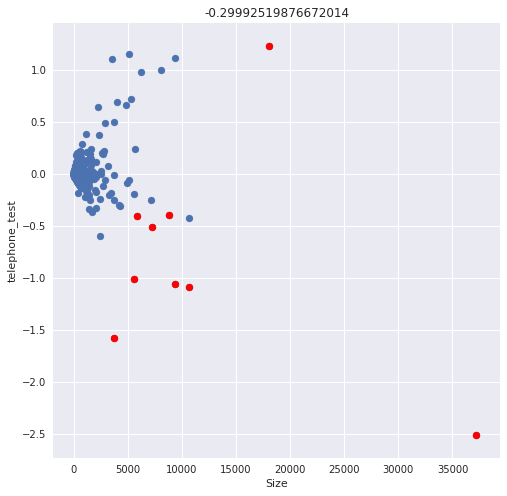

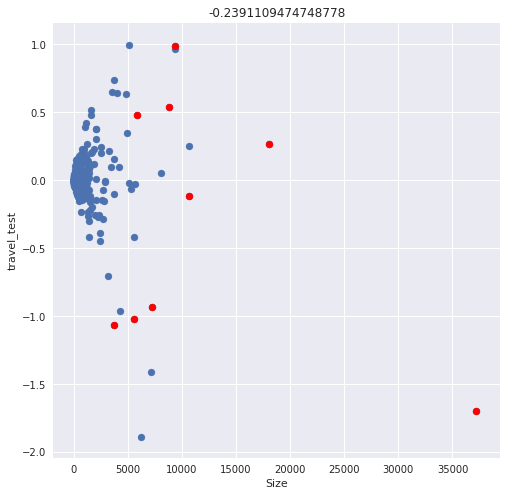

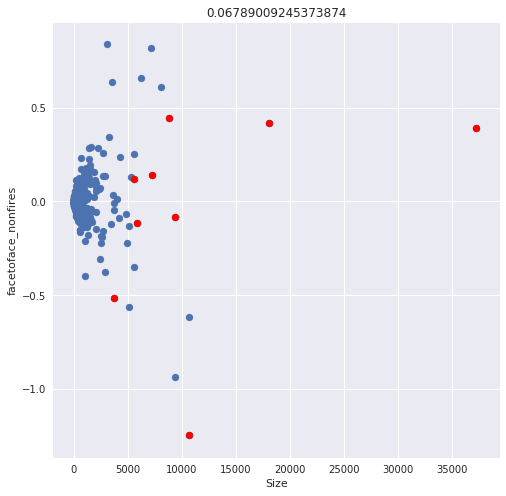

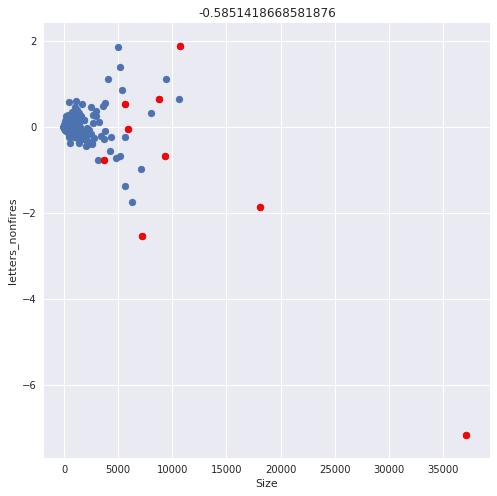

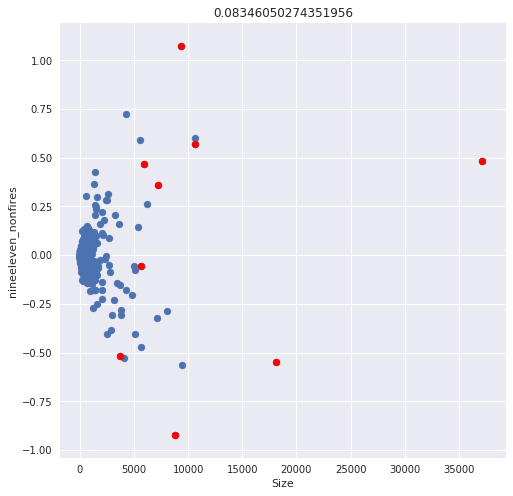

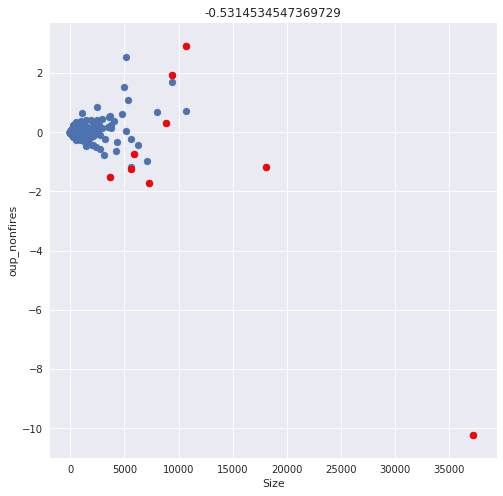

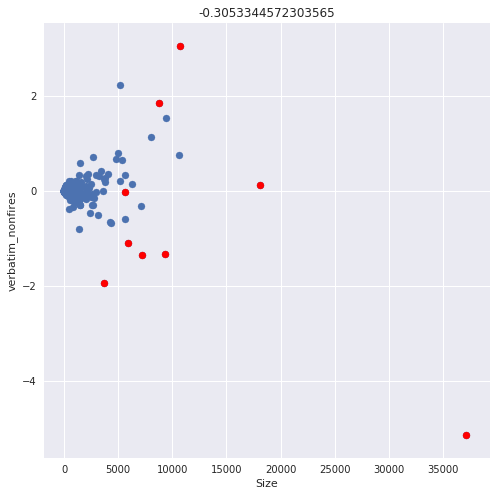

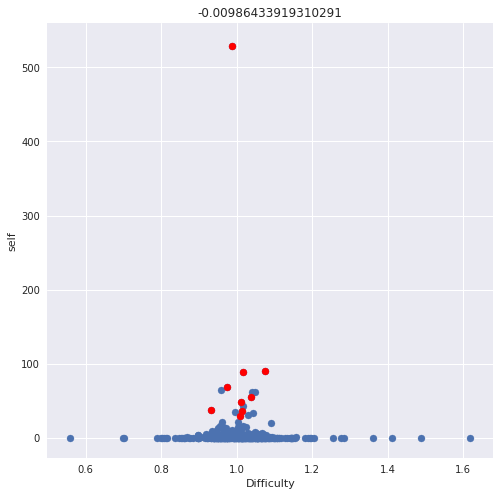

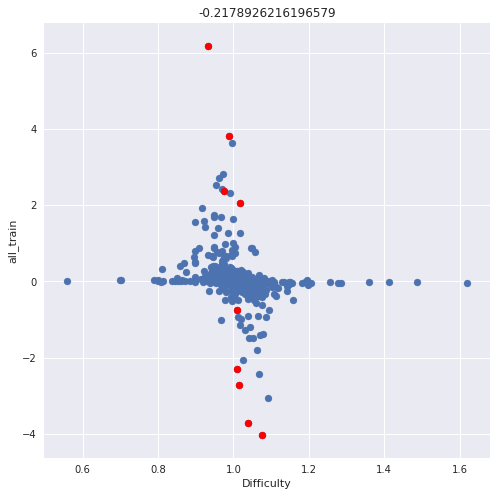

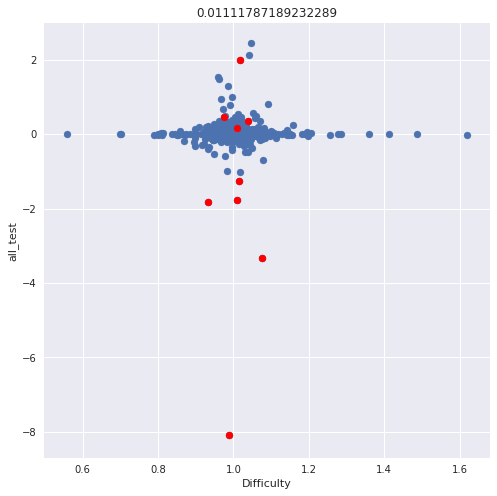

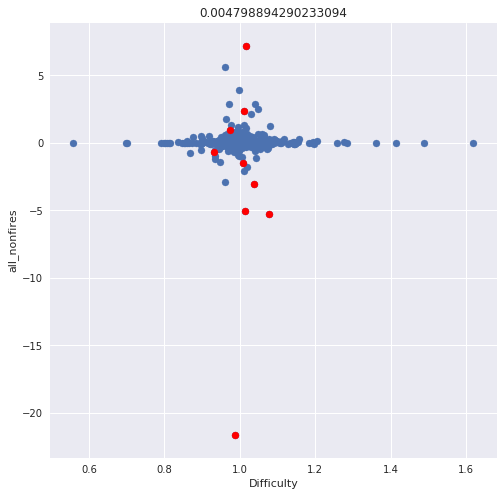

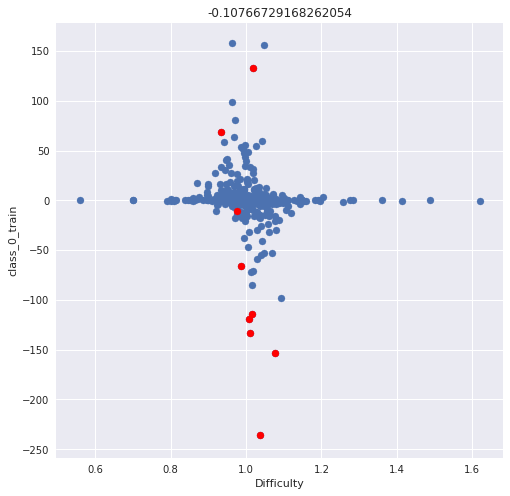

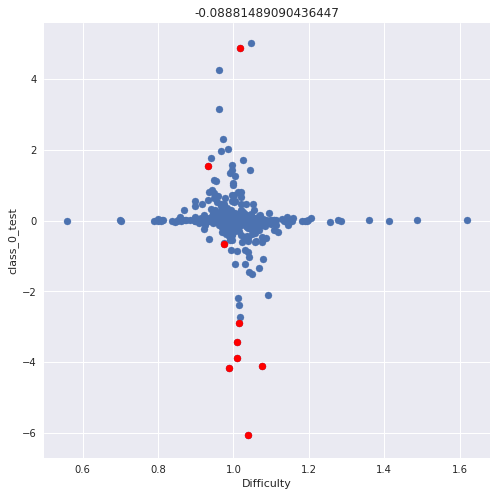

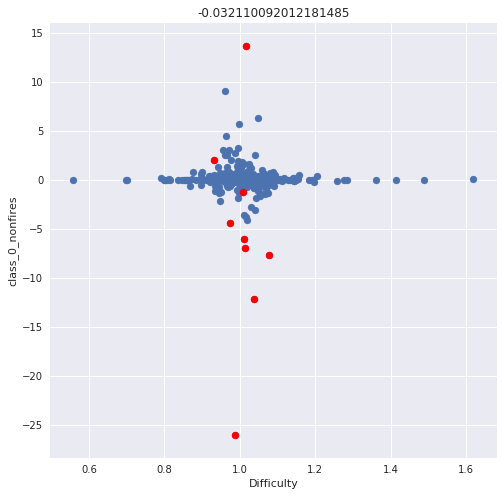

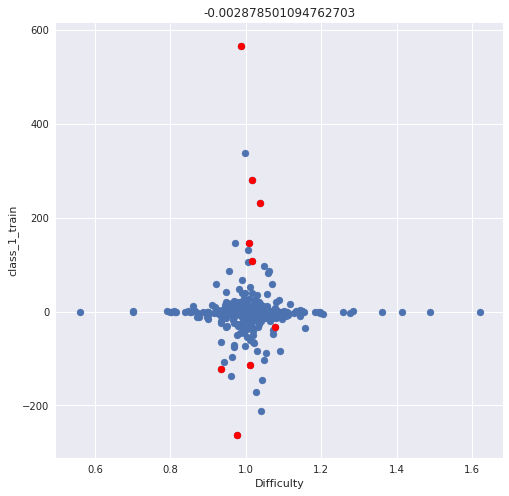

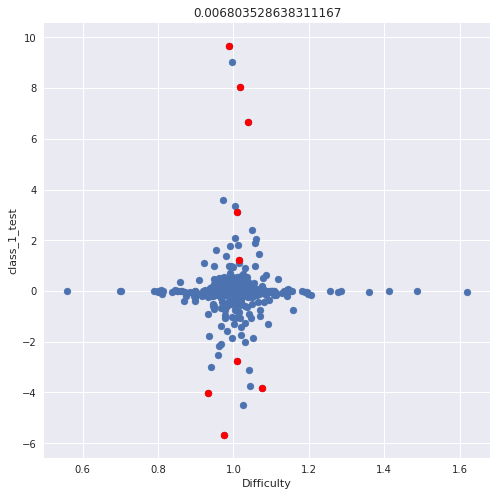

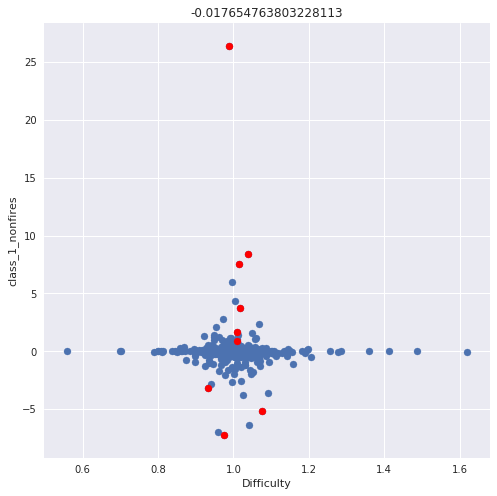

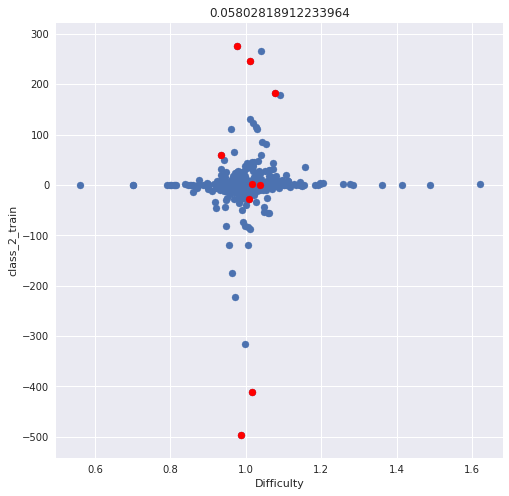

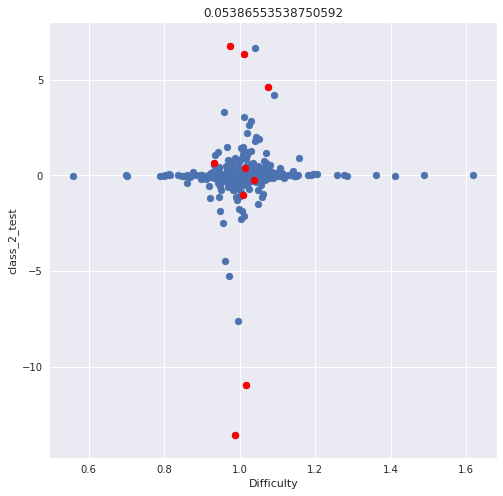

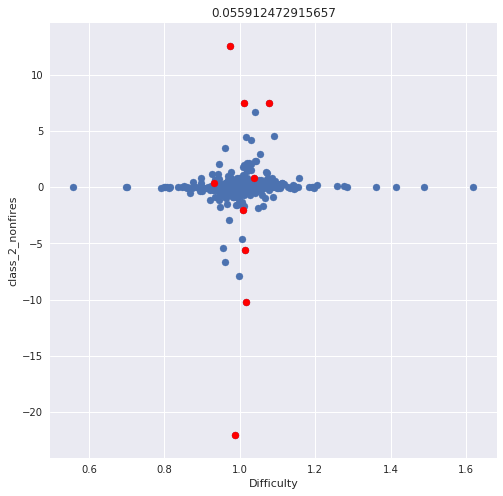

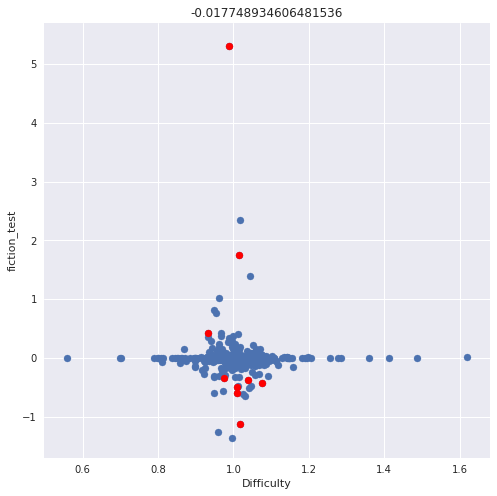

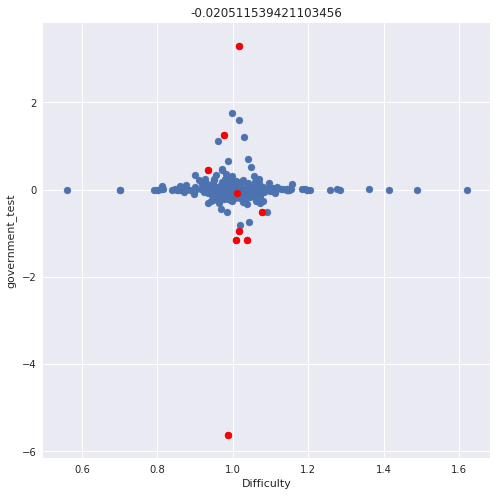

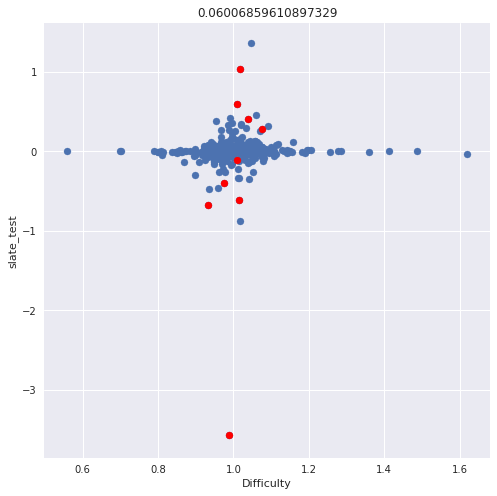

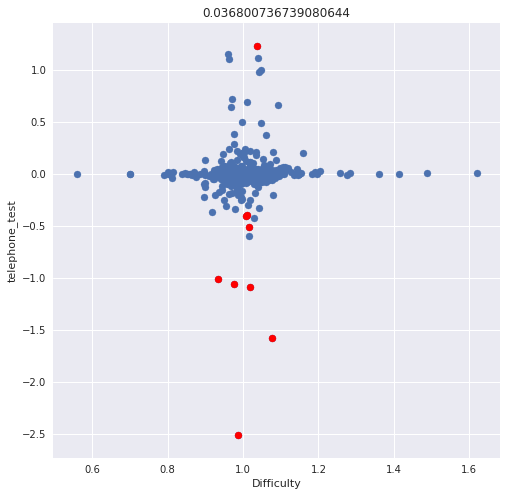

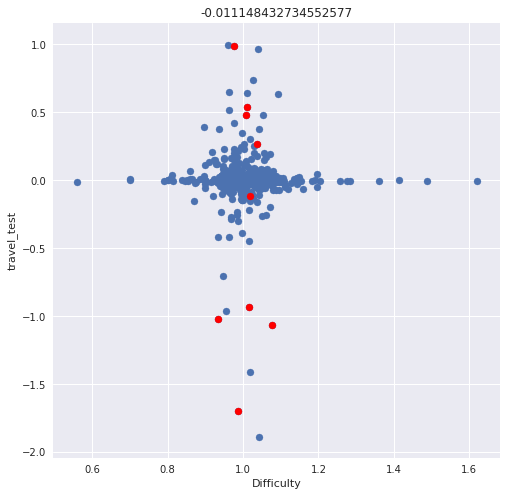

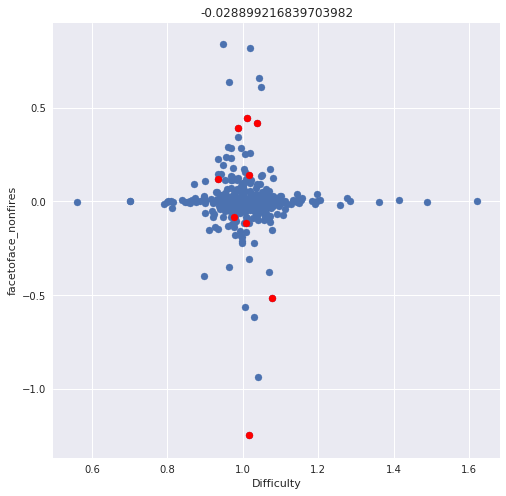

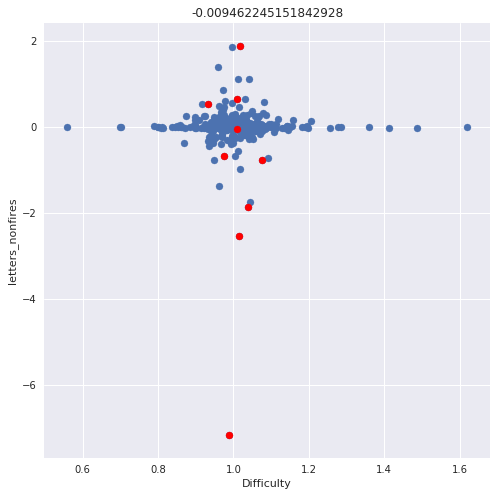

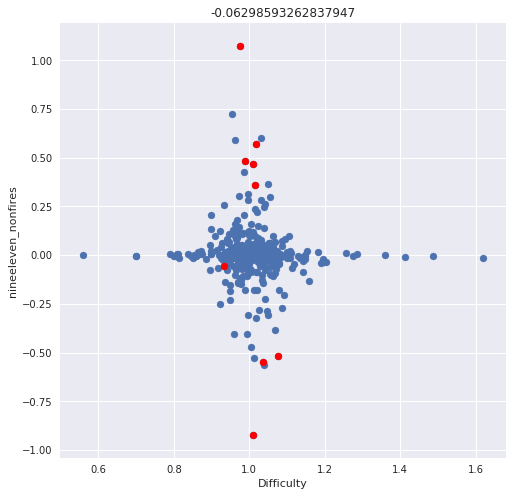

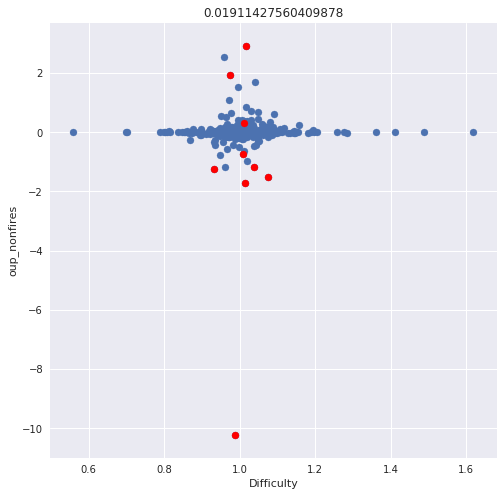

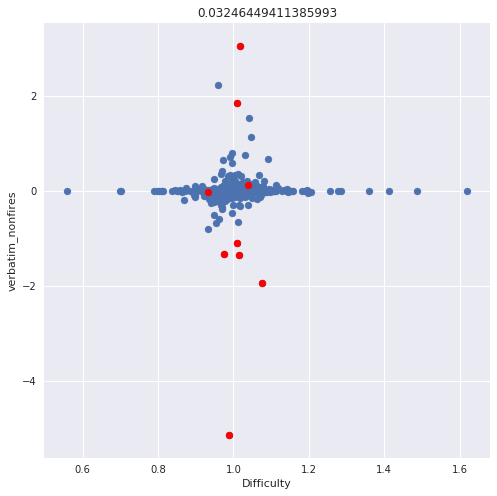

In [13]:
mask = range(num_groups-5)
interesting = [351, 226, 127, 359, 251, 133, 58, 96, 144]
for meta, name in zip(metas, meta_names):
    meta = meta[mask]
    for prefix in all_prefixes:
        y = exp.R[prefix + infl_names[0]][mask]
        fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
        scatter(ax[0][0], meta, y, name, prefix)
        ax[0][0].scatter(meta[interesting], y[interesting], c='r')

In [14]:
a=np.where(subset_sizes>35000)[0]
print(a)
print(subset_tags[a])

[351 380 381 382 383 384]
[u'same_turker-XXWO' u'same_genre-fiction' u'same_genre-government'
 u'same_genre-slate' u'same_genre-telephone' u'same_genre-travel']


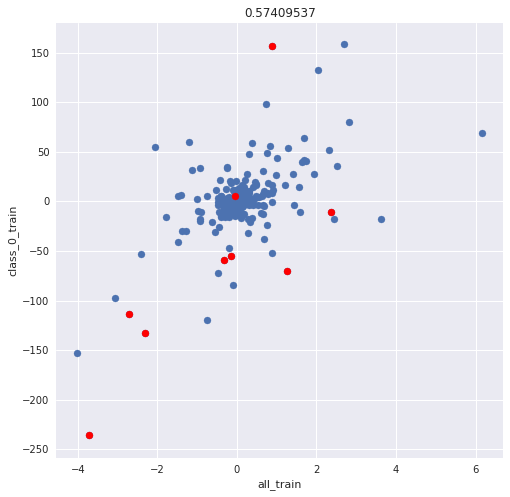

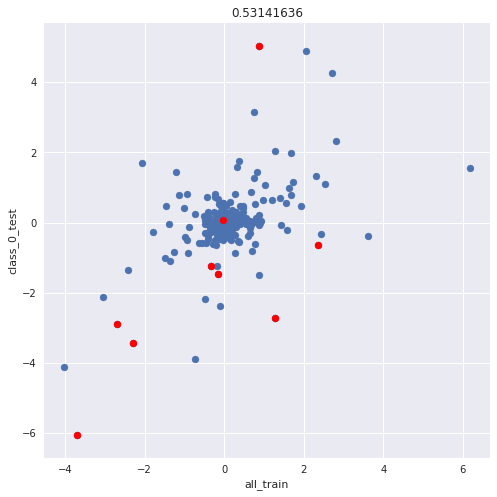

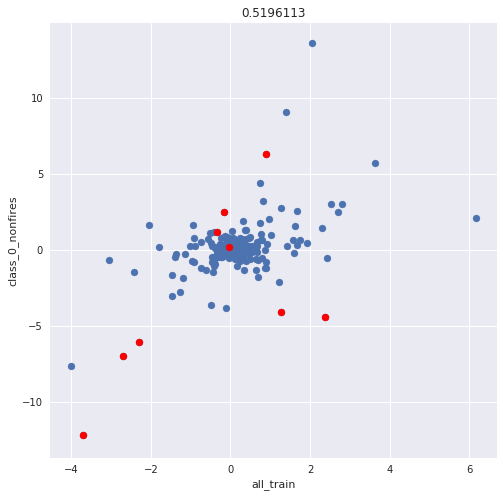

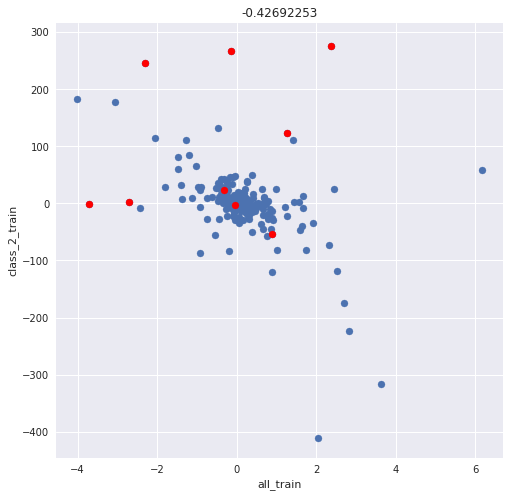

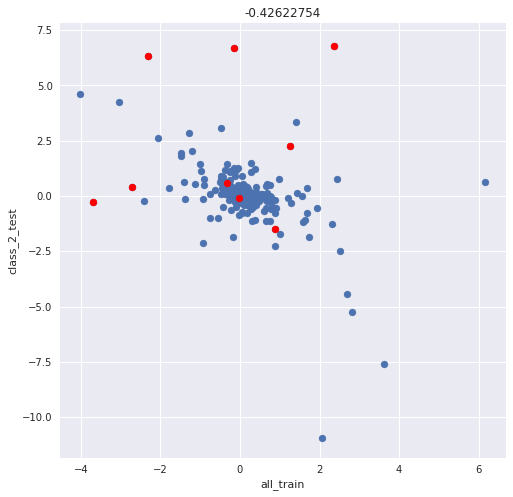

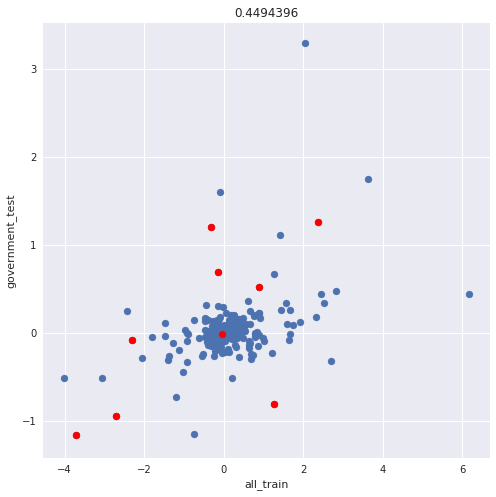

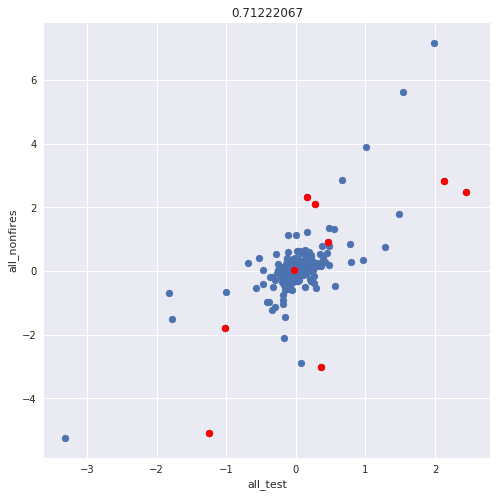

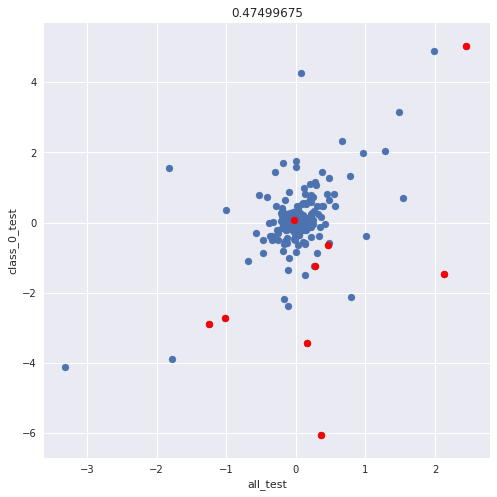

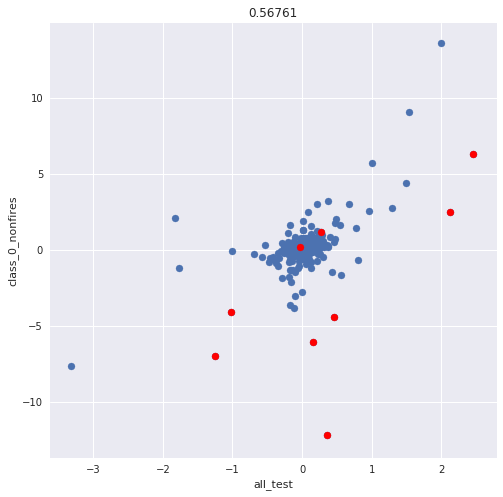

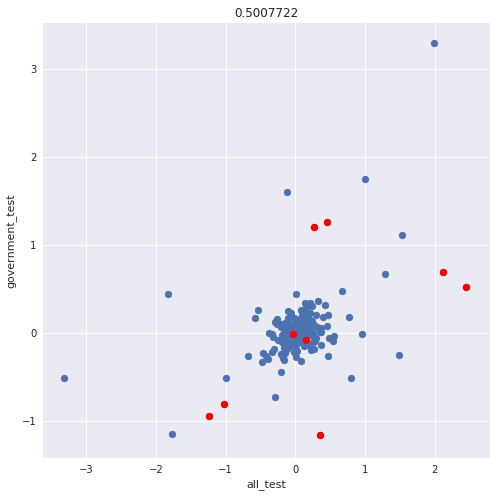

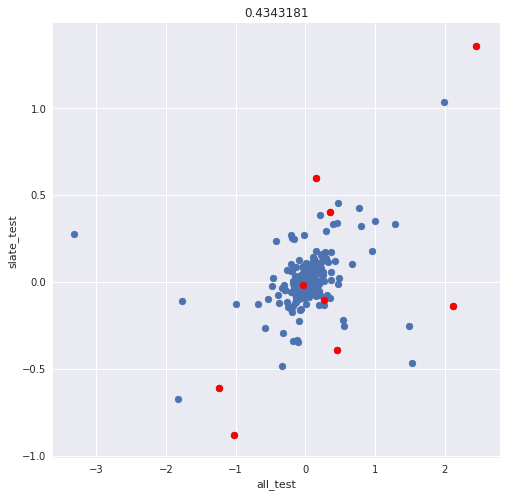

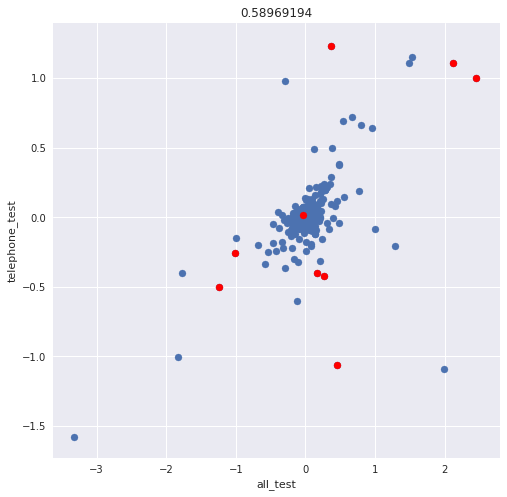

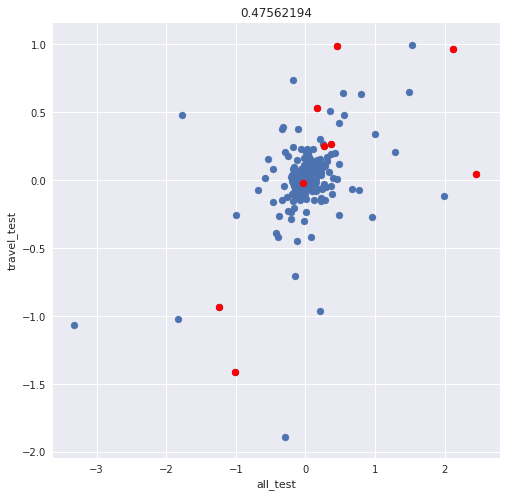

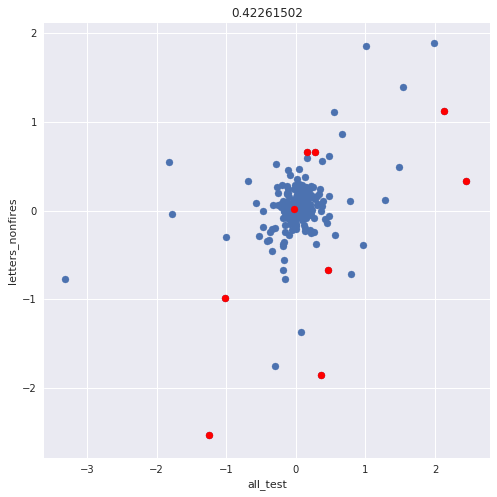

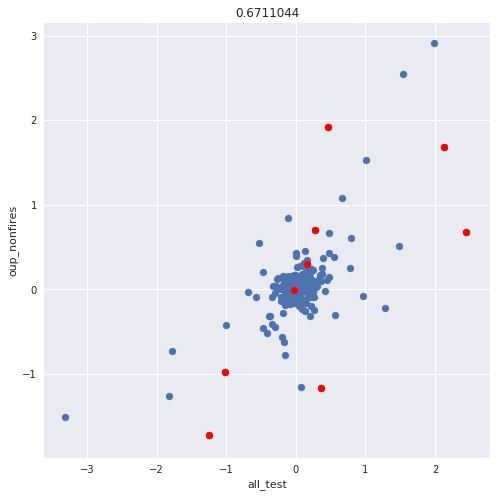

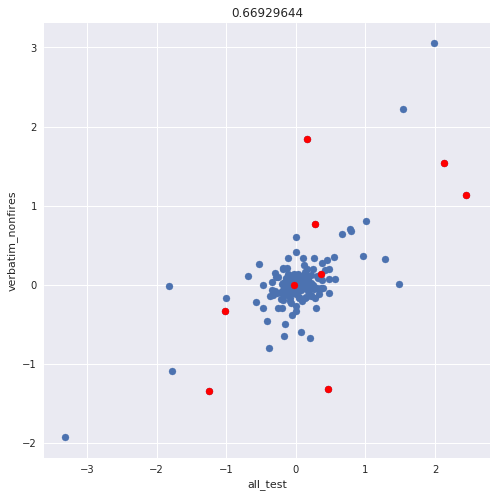

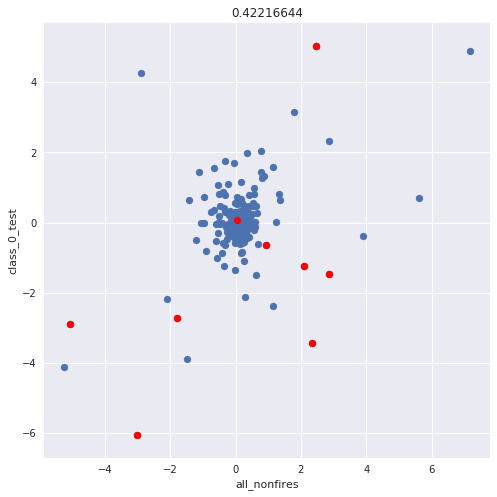

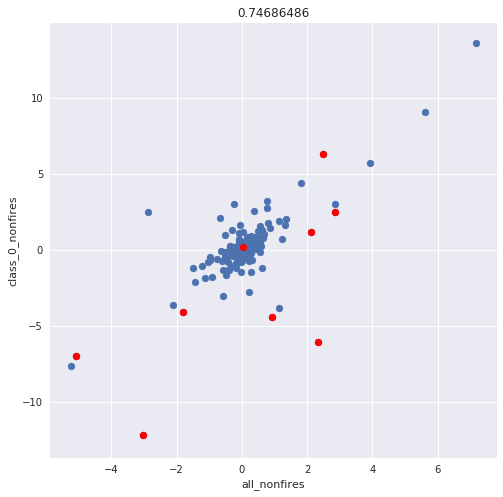

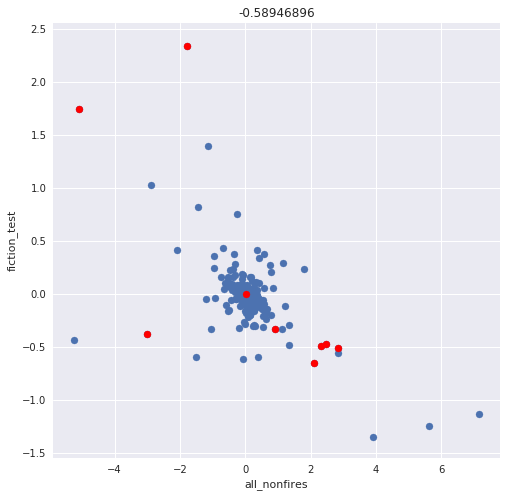

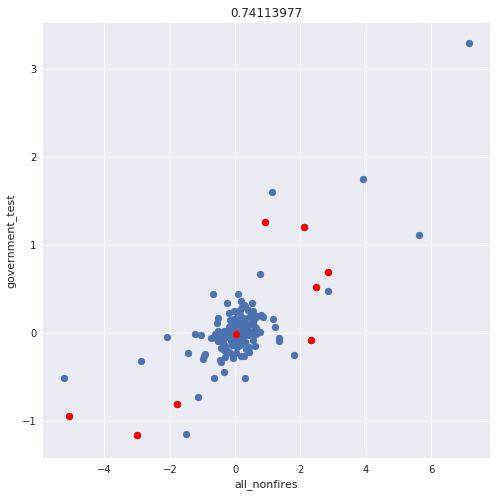

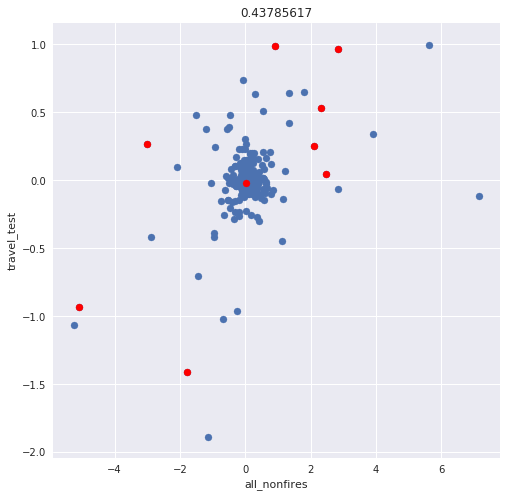

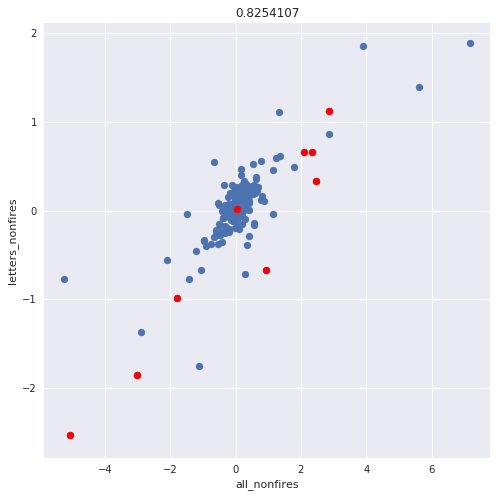

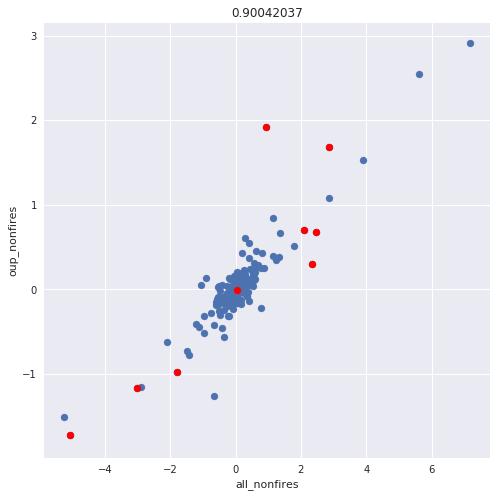

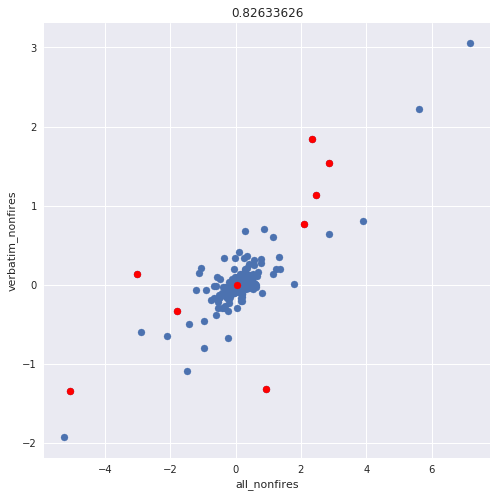

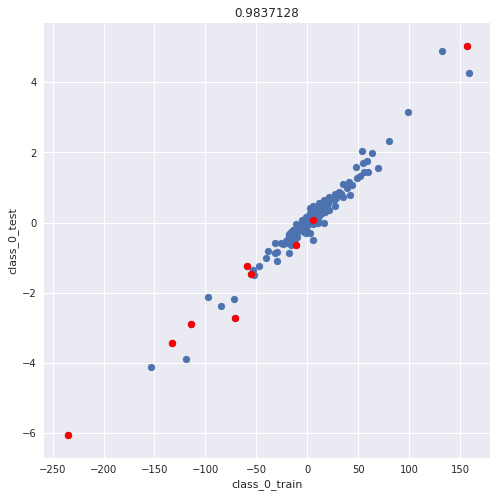

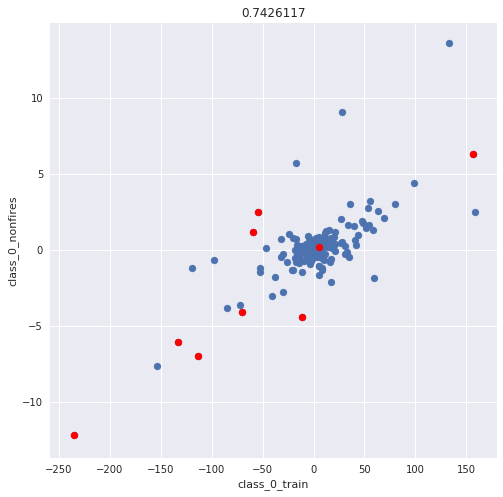

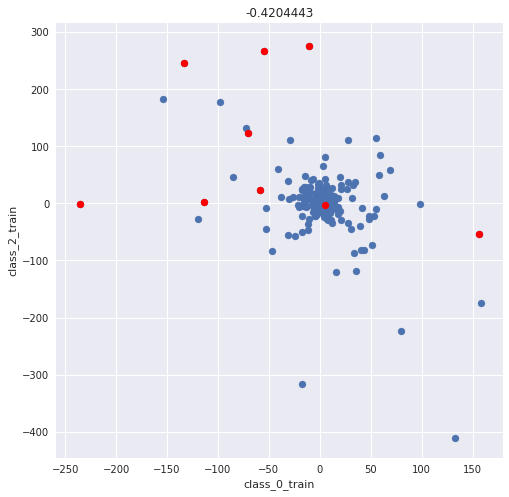

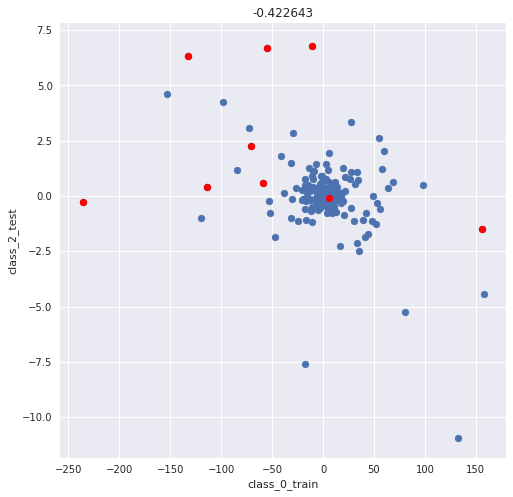

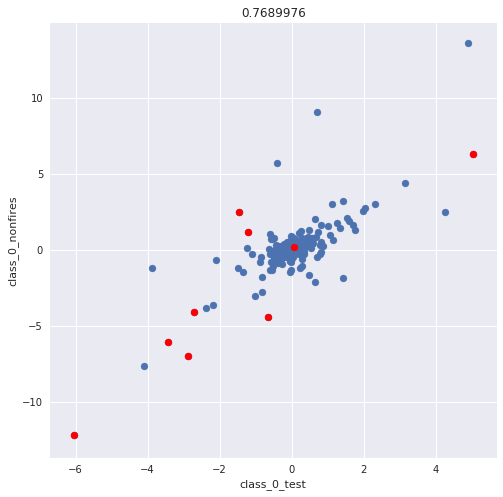

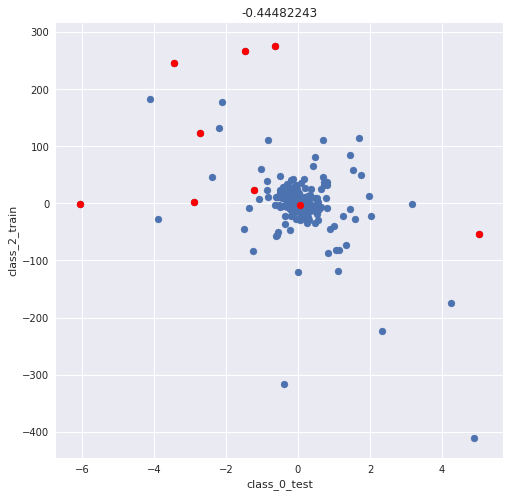

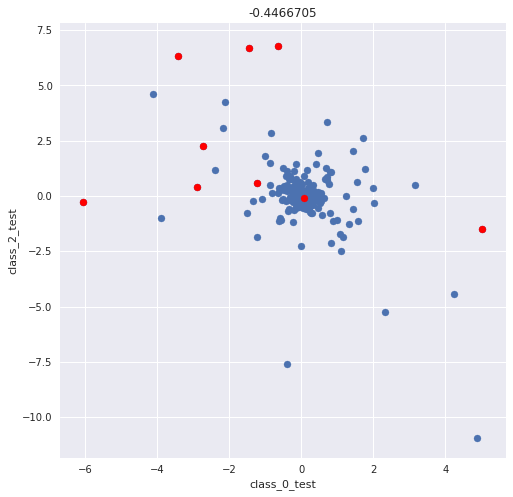

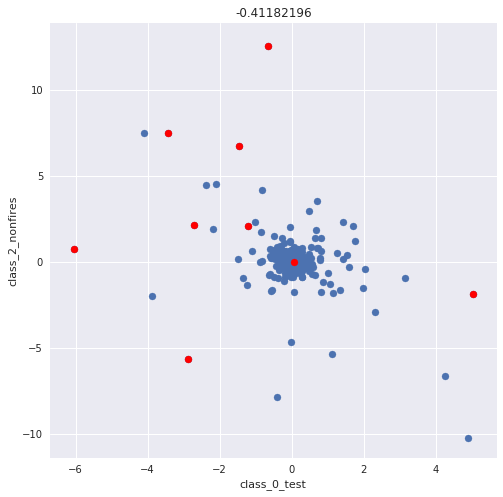

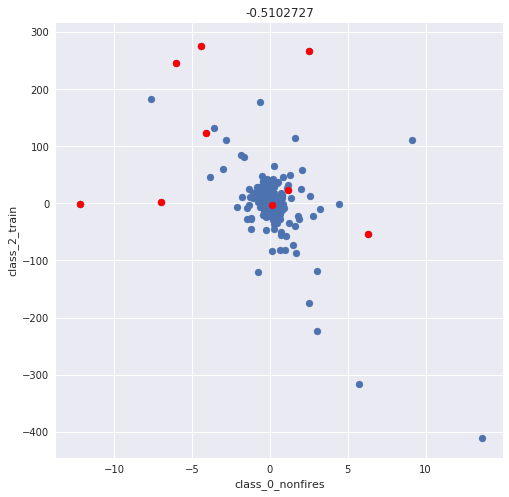

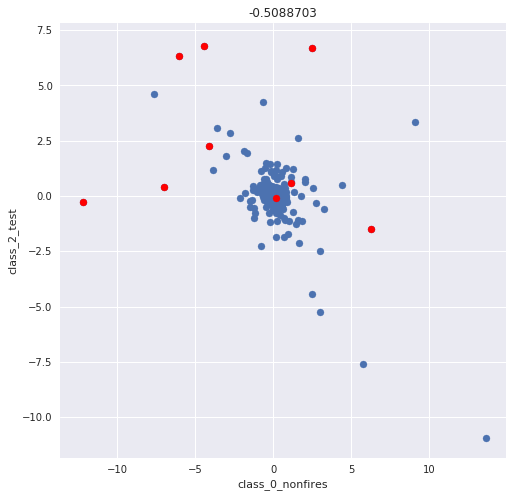

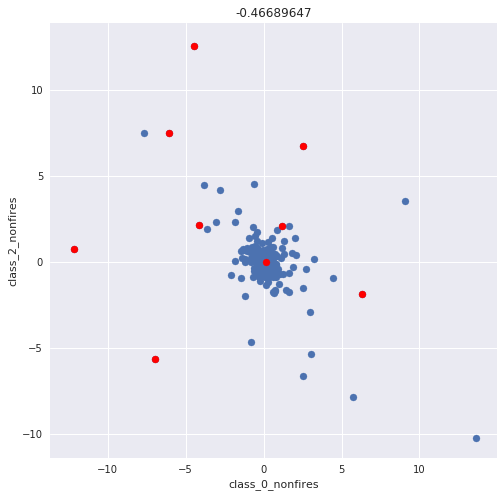

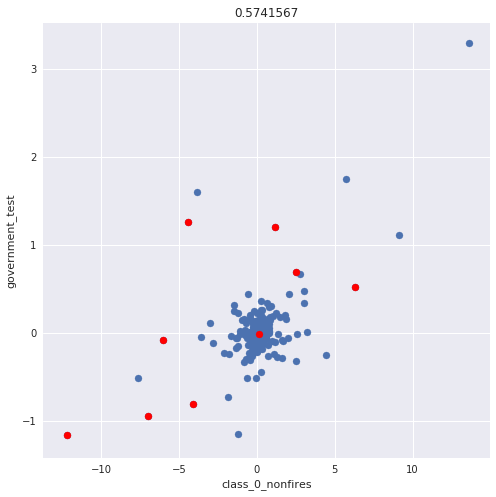

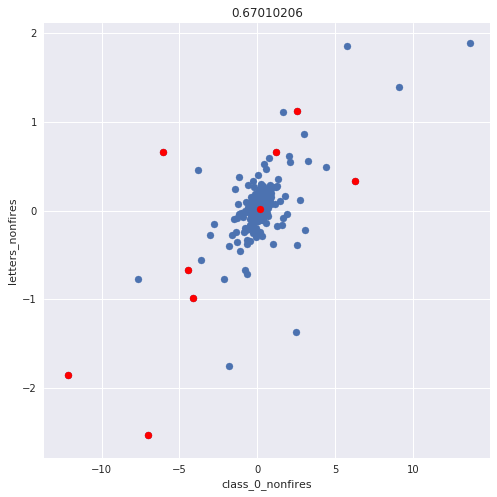

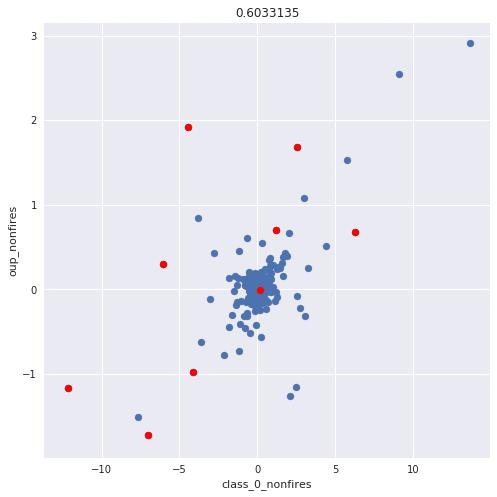

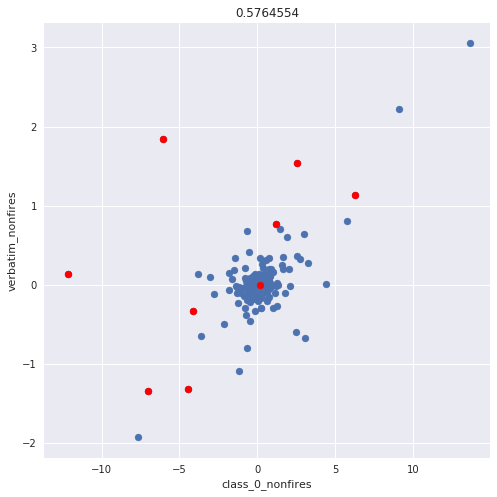

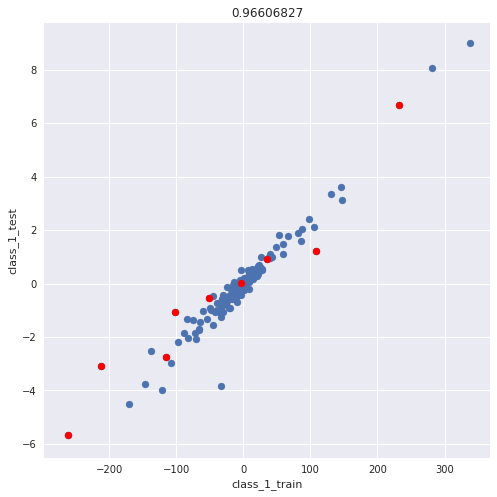

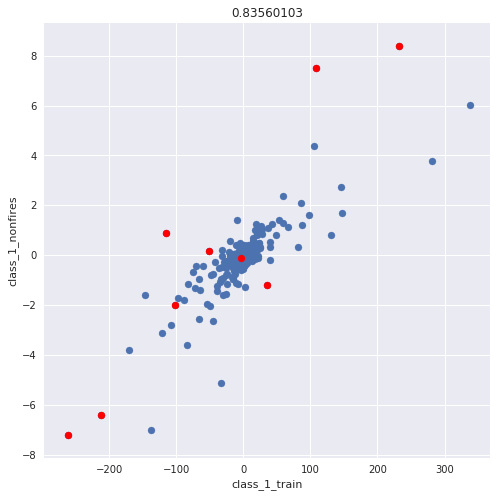

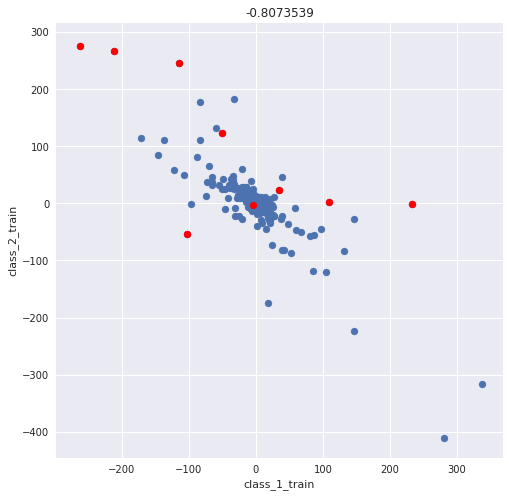

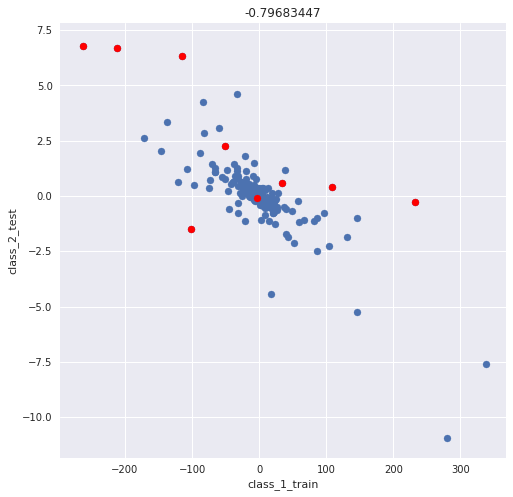

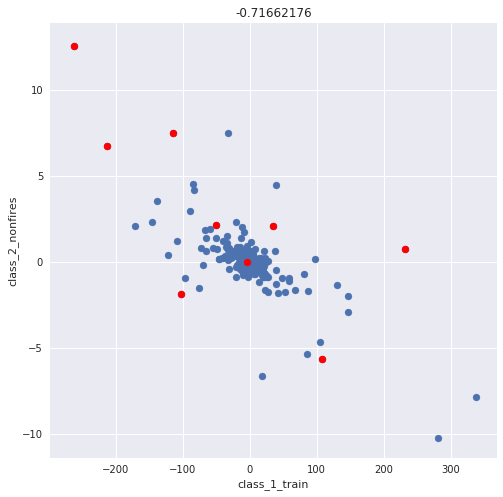

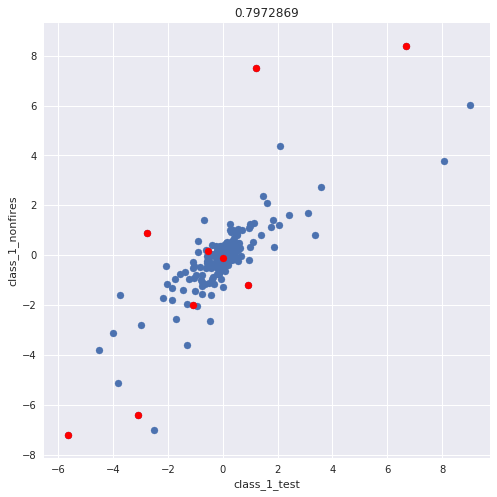

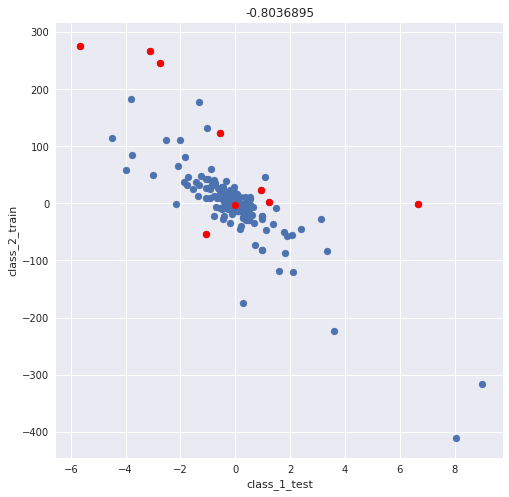

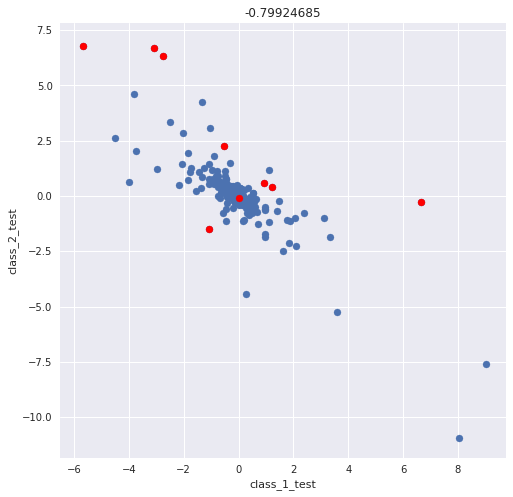

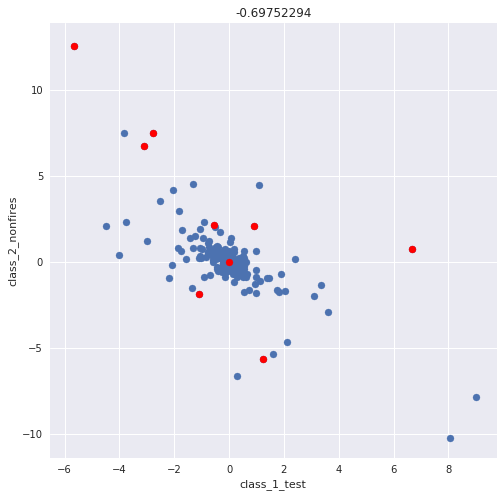

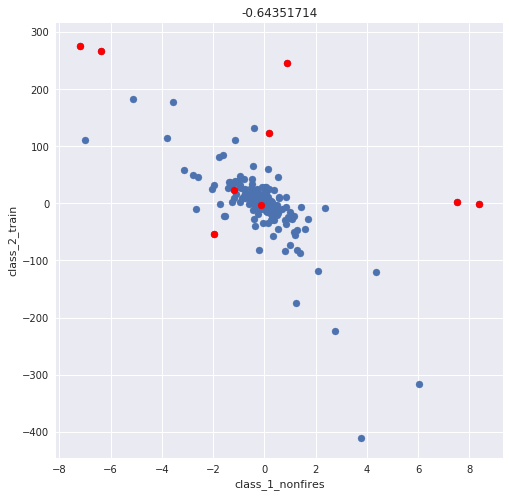

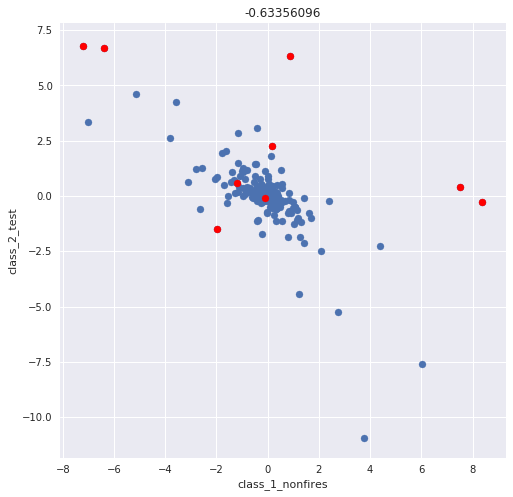

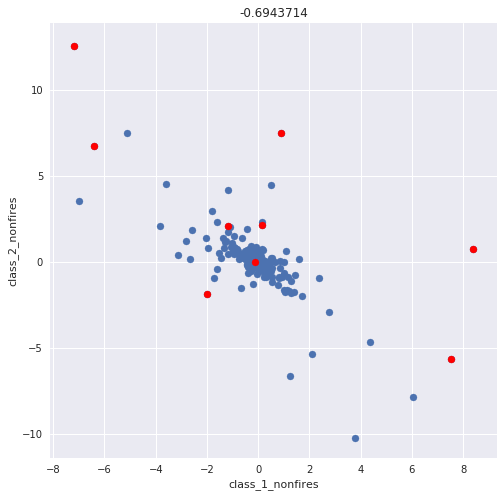

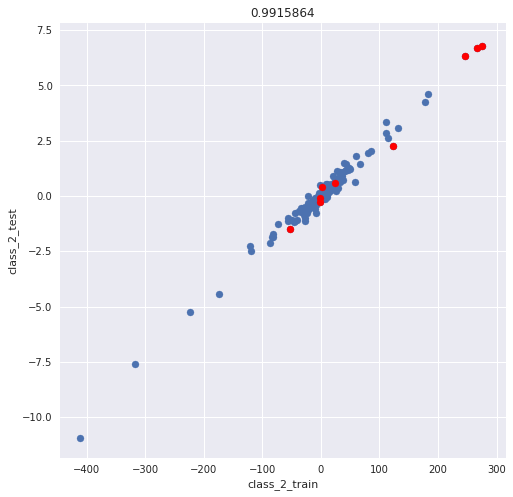

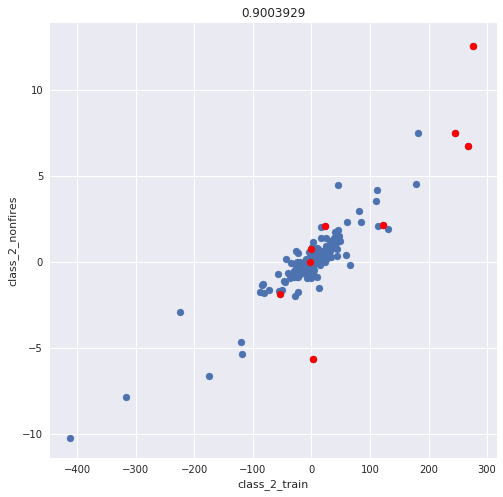

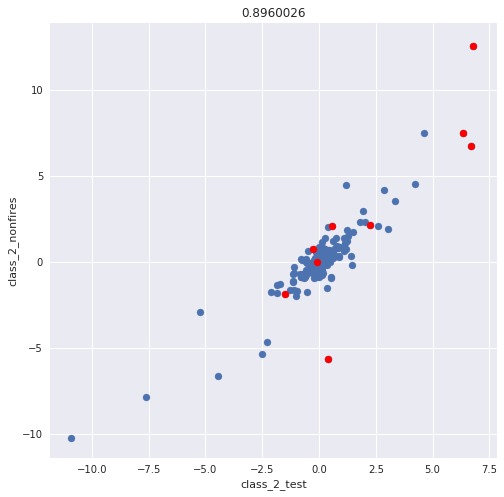

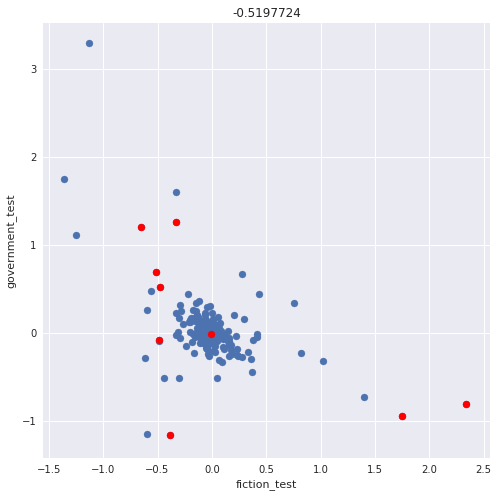

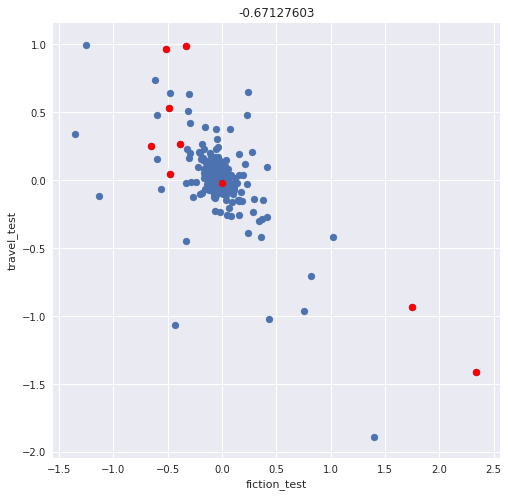

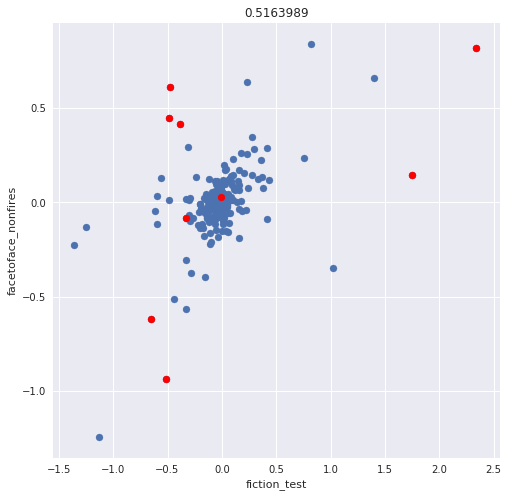

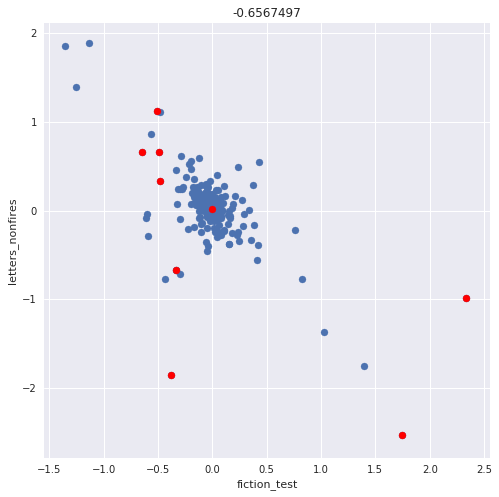

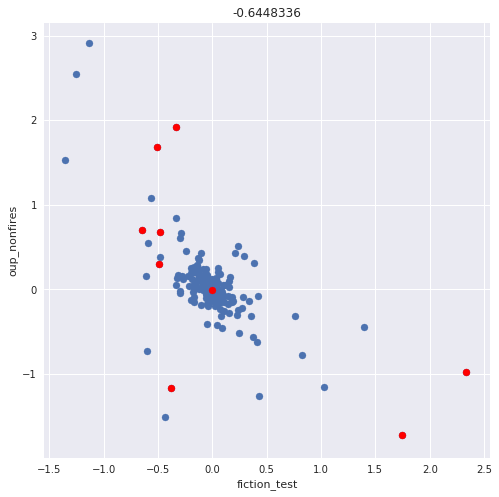

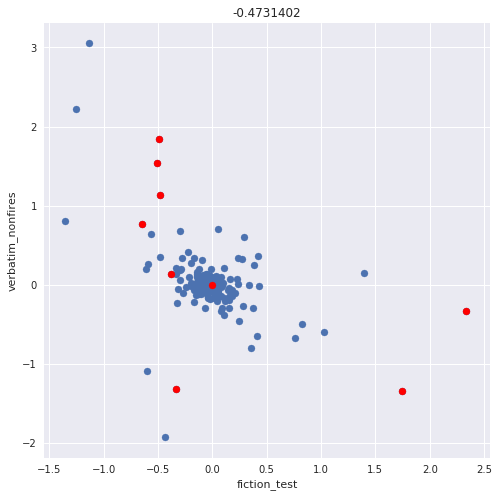

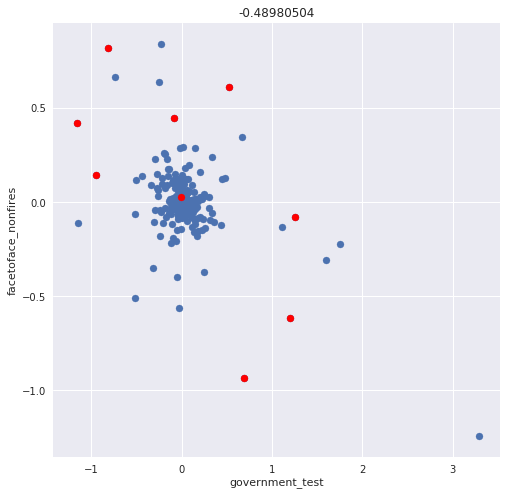

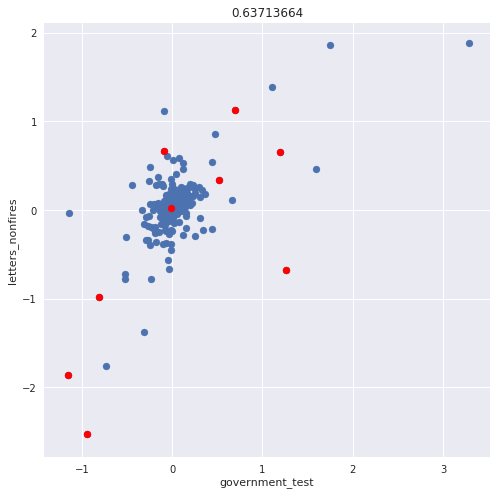

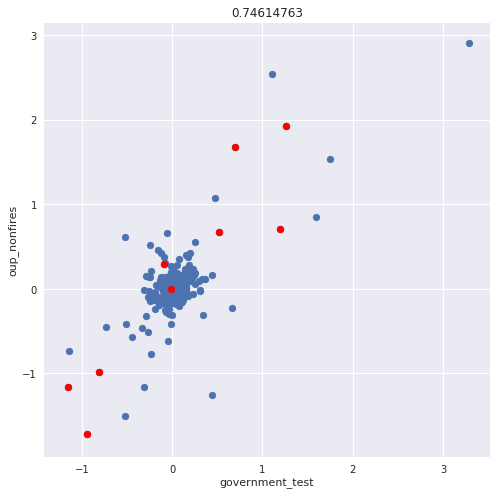

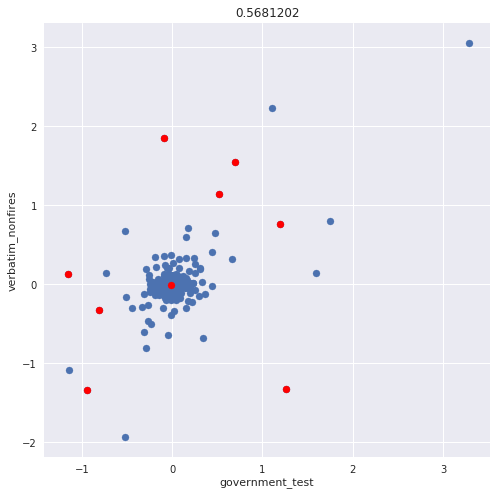

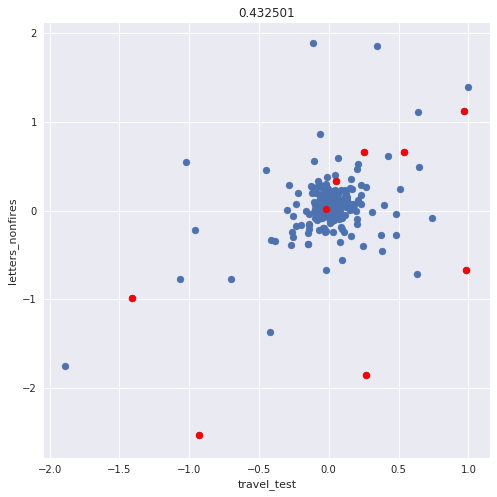

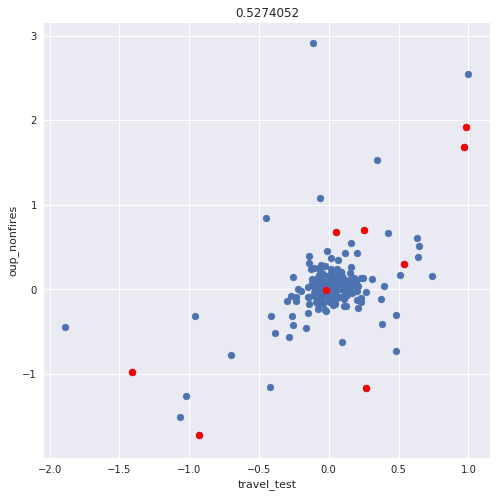

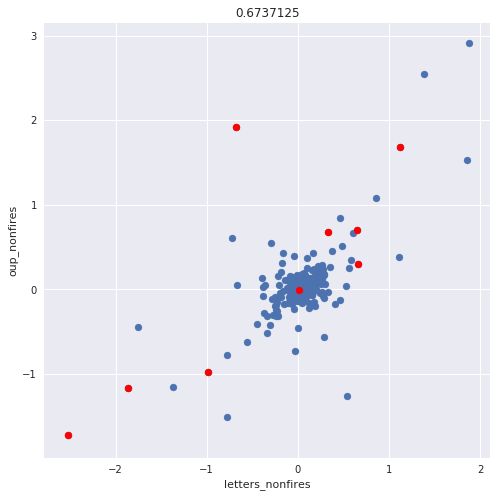

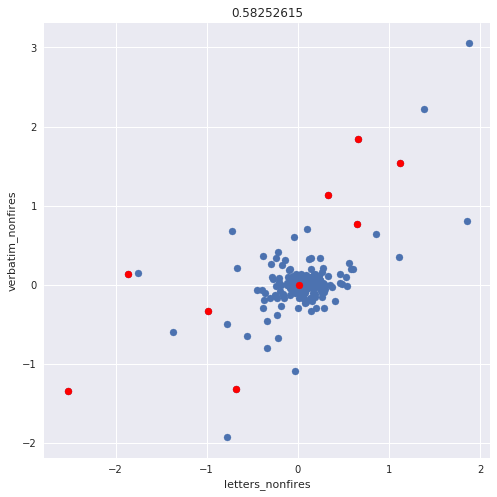

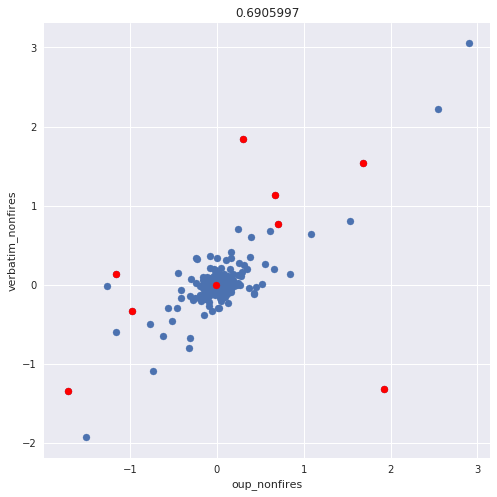

In [37]:
prolific = np.argsort(np.sum(genre_contribs[:-5], axis=1))[-10:-1]
mask = mask[:351] + mask[352:]
for i in range(num_prefixes):
    for j in range(i+1,num_prefixes):
        x = exp.R[all_prefixes[i] + infl_names[0]][mask]
        y = exp.R[all_prefixes[j] + infl_names[0]][mask]
        if np.abs(calcR(x,y)) > 0.4:
            fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
            scatter(ax[0][0], x, y, all_prefixes[i], all_prefixes[j])
            ax[0][0].scatter(x[prolific], y[prolific], c='r')

In [73]:
a = np.intersect1d(np.where(exp.R['class_1_test_pred_infl']<2)[0],\
                     np.where(exp.R['class_1_nonfires_pred_infl']>6)[0])
print(a)
print(subset_tags[a])

[58]
[u'same_turker-EEIG']


[u'all_train', u'all_test', u'all_nonfires', u'class_0_train', u'class_0_test', u'class_0_nonfires', u'class_1_train', u'class_1_test', u'class_1_nonfires', u'class_2_train', u'class_2_test', u'class_2_nonfires']
1.0
0.57409537
0.53141636
0.5196113
-0.42692253
-0.42622754
1.0
0.71222067
0.47499675
0.56761
0.71222067
1.0
0.42216644
0.74686486
0.57409537
1.0
0.9837128
0.7426117
-0.4204443
-0.422643
0.53141636
0.47499675
0.42216644
0.9837128
1.0
0.7689976
-0.44482243
-0.4466705
-0.41182196
0.5196113
0.56761
0.74686486
0.7426117
0.7689976
1.0
-0.5102727
-0.5088703
-0.46689647
1.0
0.96606827
0.83560103
-0.8073539
-0.79683447
-0.71662176
0.96606827
1.0
0.7972869
-0.8036895
-0.79924685
-0.69752294
0.83560103
0.7972869
1.0
-0.64351714
-0.63356096
-0.6943714
-0.42692253
-0.4204443
-0.44482243
-0.5102727
-0.8073539
-0.8036895
-0.64351714
1.0
0.9915864
0.9003929
-0.42622754
-0.422643
-0.4466705
-0.5088703
-0.79683447
-0.79924685
-0.63356096
0.9915864
1.0
0.8960026
-0.41182196
-0.46689647
-0.71662

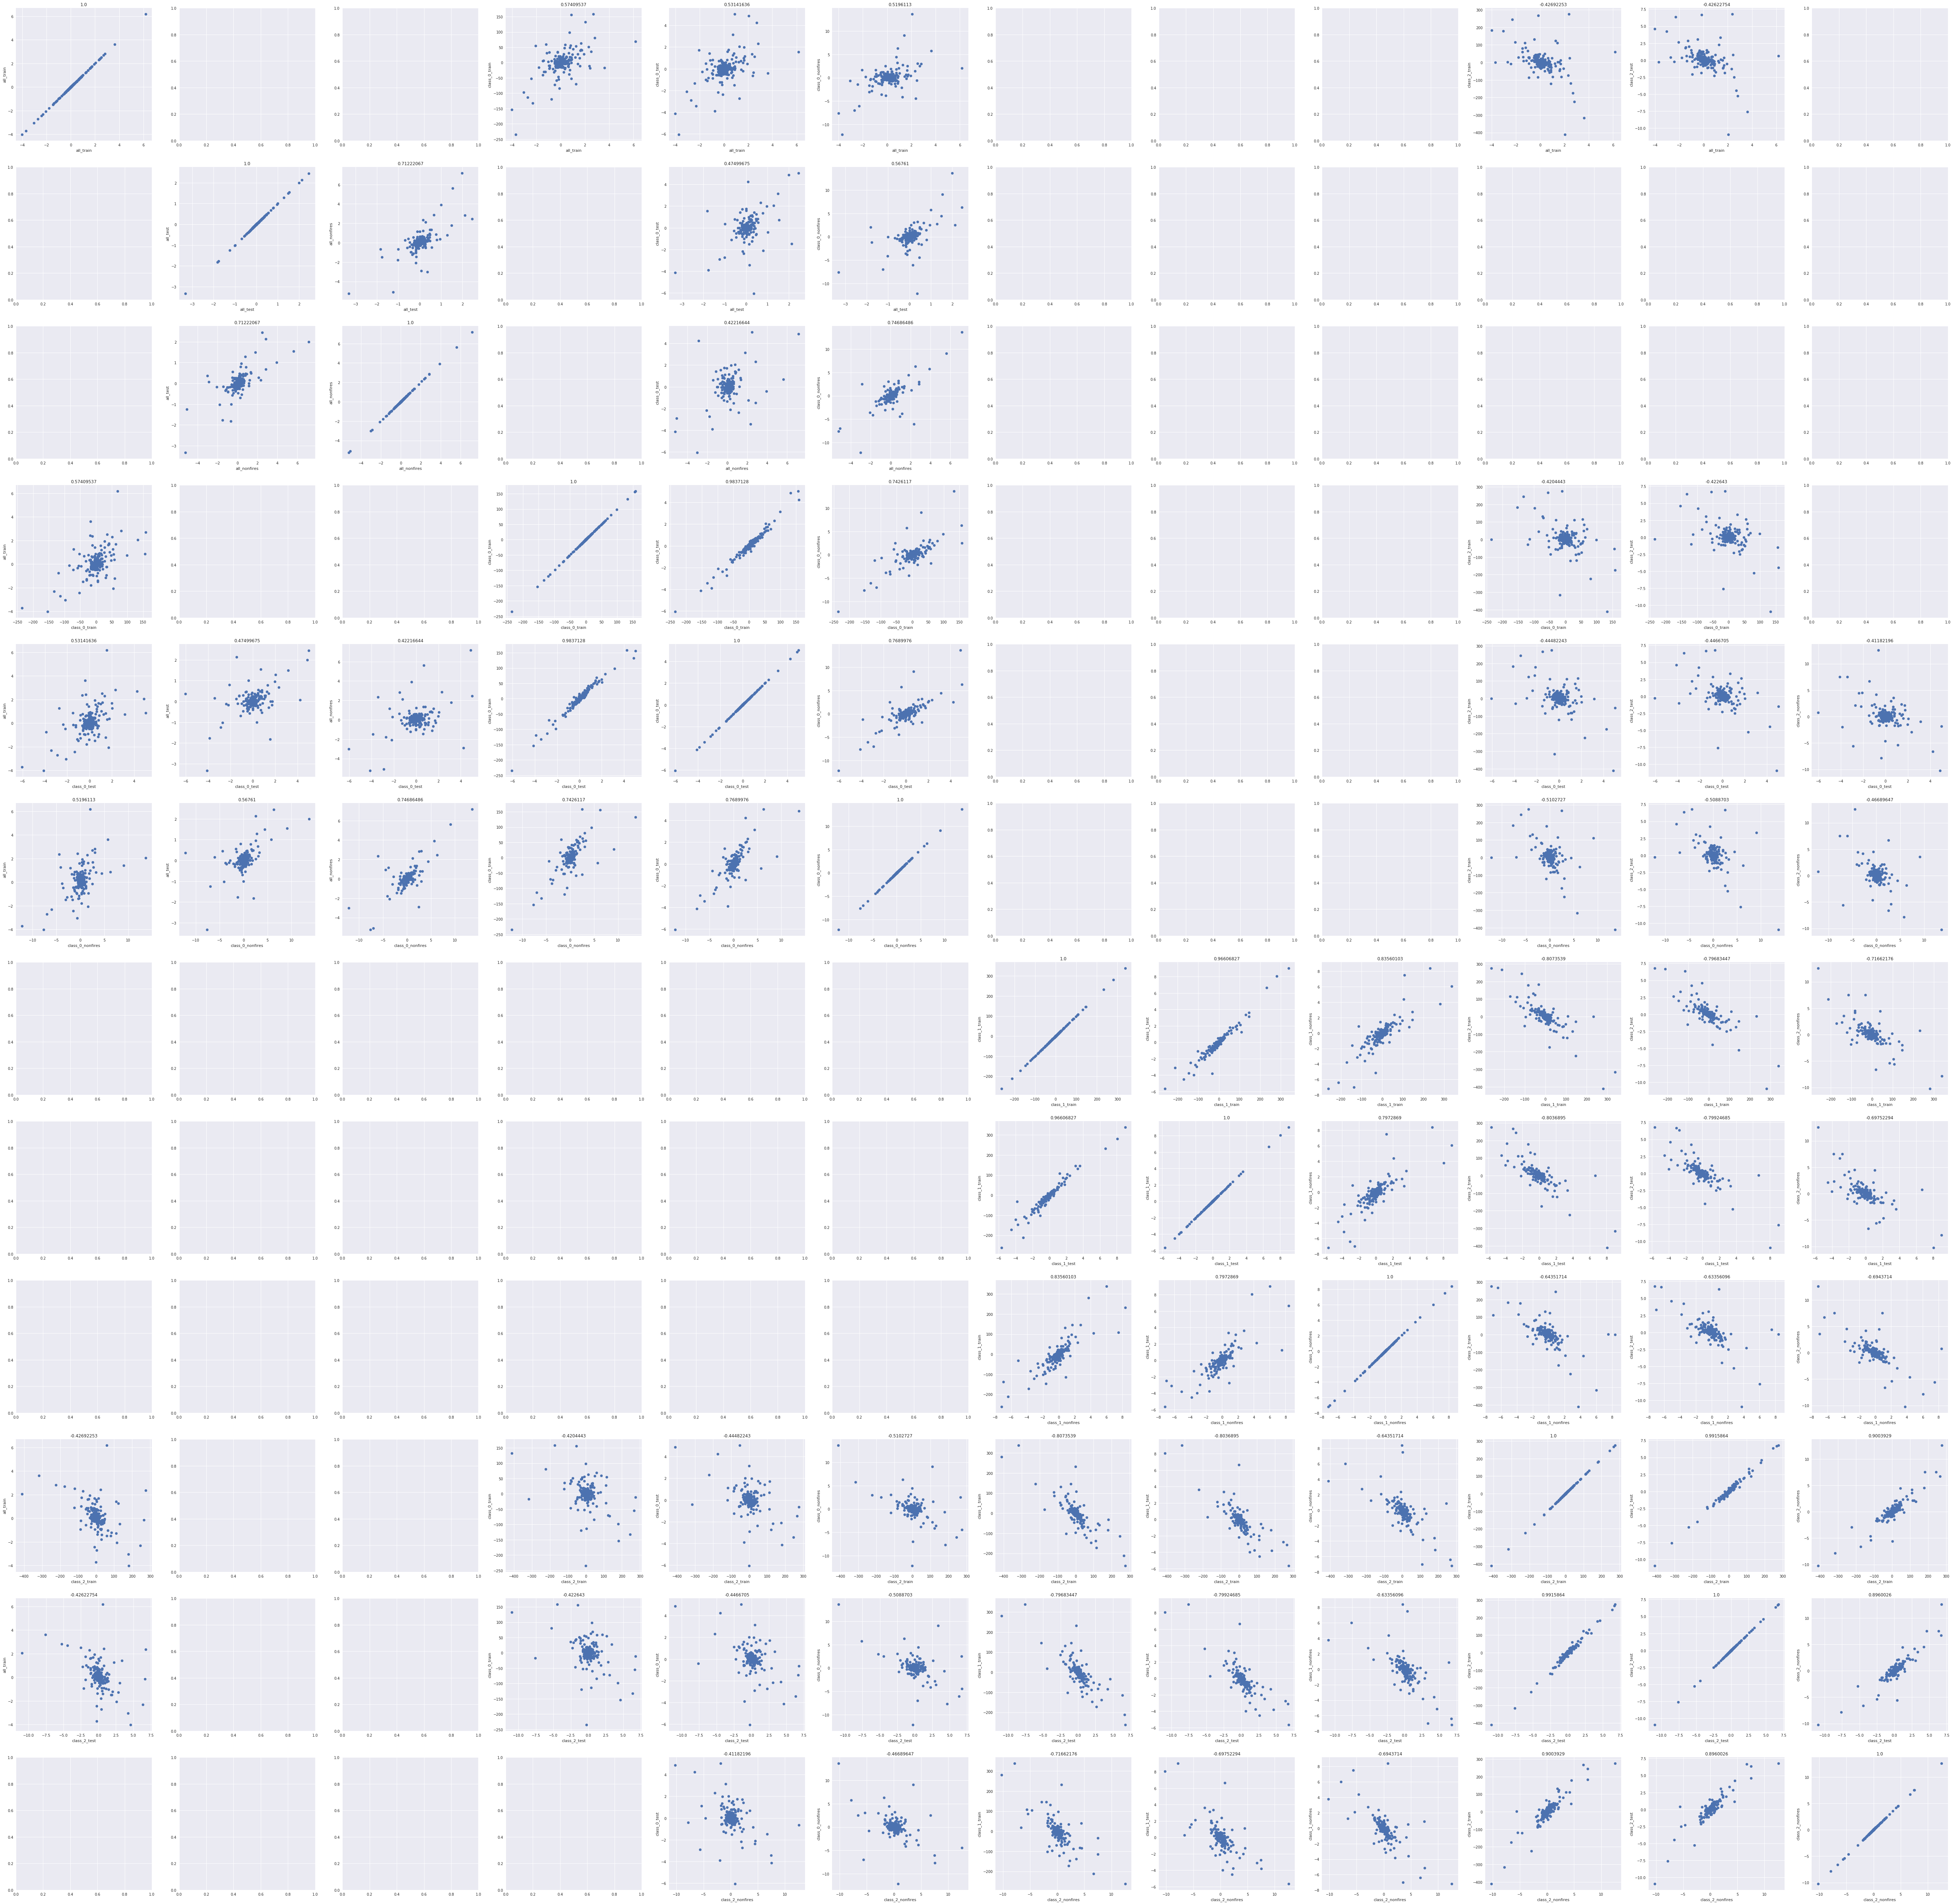

In [78]:
fig, ax = plt.subplots(12,12,figsize=(96,96),squeeze=False)
for i, p1 in enumerate(scoped_prefixes):
    for j, p2 in enumerate(scoped_prefixes):
        x = exp.R[p1+'_pred_infl'][mask]
        y = exp.R[p2+'_pred_infl'][mask]
        if np.abs(calcR(x,y)) > 0.4:
            scatter(ax[j][i], x, y, p1, p2)

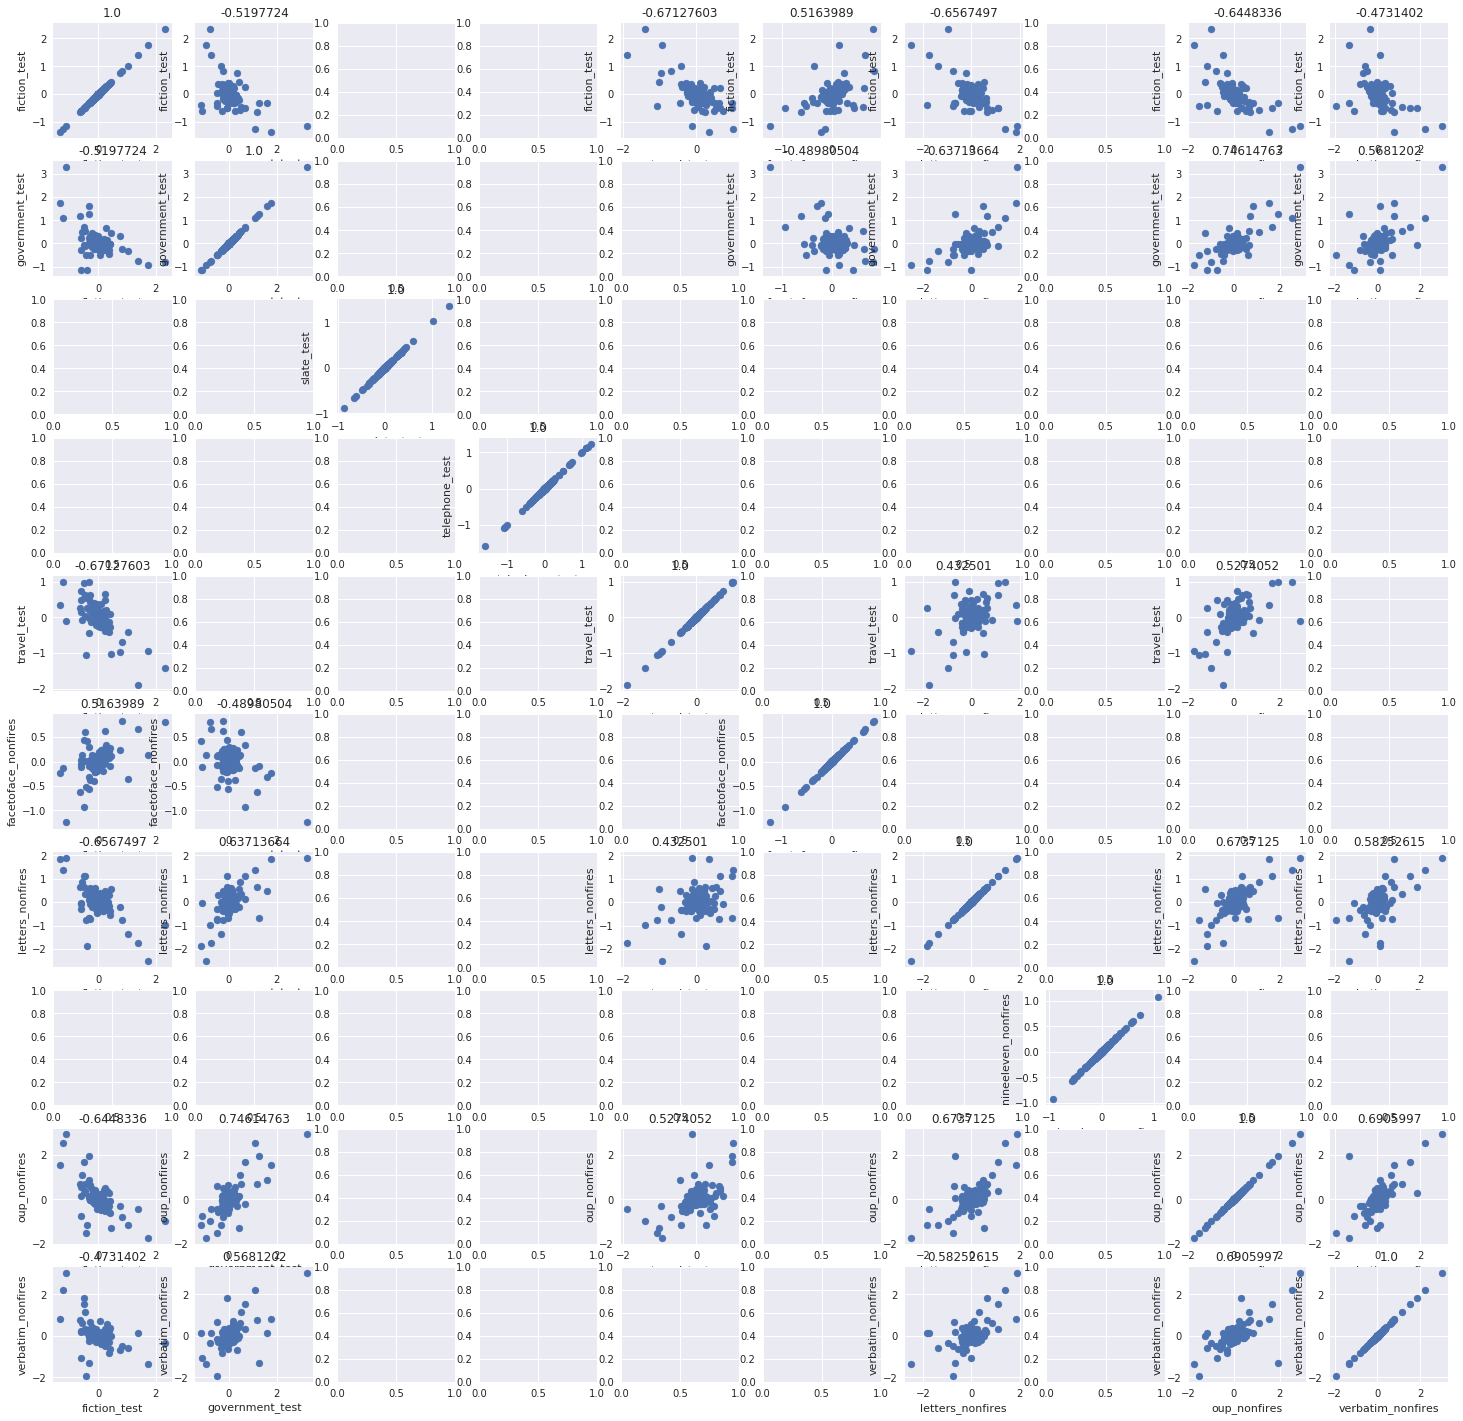

In [6]:
fig, ax = plt.subplots(10,10,figsize=(25,25),squeeze=False)
for i, p1 in enumerate(test_gen_prefixes+nonf_gen_prefixes):
    for j, p2 in enumerate(test_gen_prefixes+nonf_gen_prefixes):
        x = exp.R[p1+'_pred_infl'][mask]
        y = exp.R[p2+'_pred_infl'][mask]
        if np.abs(calcR(x,y)) > 0.4:
            scatter(ax[j][i], x, y, p1, p2)

Pearson's R between Subset size and Self pred infl is 0.903822002228
0.9038220022275851
Pearson's R between Subset size and Tot train set pred infl is 0.137038039475
Pearson's R between Subset size and Avg nonfires pred infl is -0.00958378251488
Pearson's R between Subset size and Avg pos nonfires pred infl is 0.0665953142322
Pearson's R between Subset size and Avg neg nonfires pred infl is -0.0112031456345
Pearson's R between Accuracy and Self pred infl is -0.179269426852
Pearson's R between Accuracy and Tot train set pred infl is -0.213194624375
Pearson's R between Accuracy and Avg nonfires pred infl is 0.317797970864
Pearson's R between Accuracy and Avg pos nonfires pred infl is -0.331614219077
Pearson's R between Accuracy and Avg neg nonfires pred infl is 0.318261126663
-----------------------------
Pearson's R between Subset size and Tot train set pred infl normalized is -0.449726653981
-0.44972665398059725
Pearson's R between Subset size and Avg nonfires pred infl normalized is -

/u/nlp/packages/anaconda2/envs/tf-kaiang/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


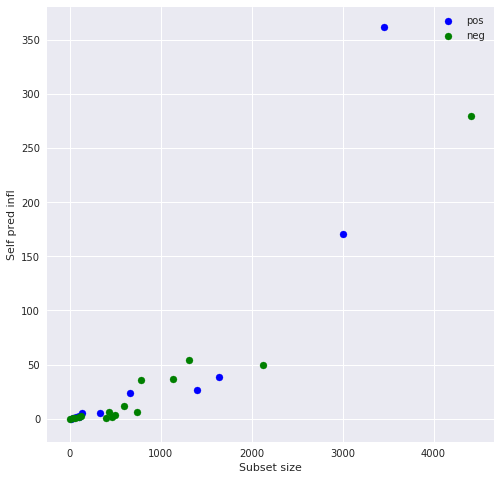

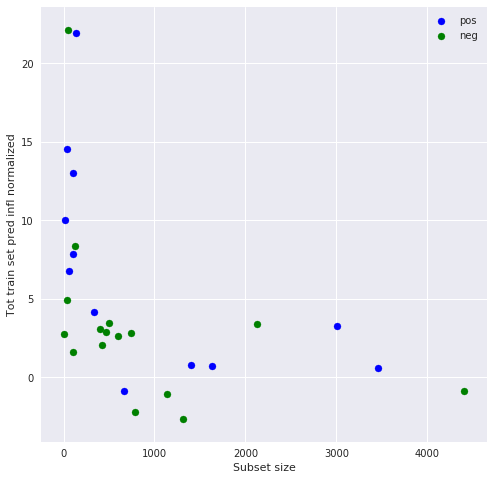

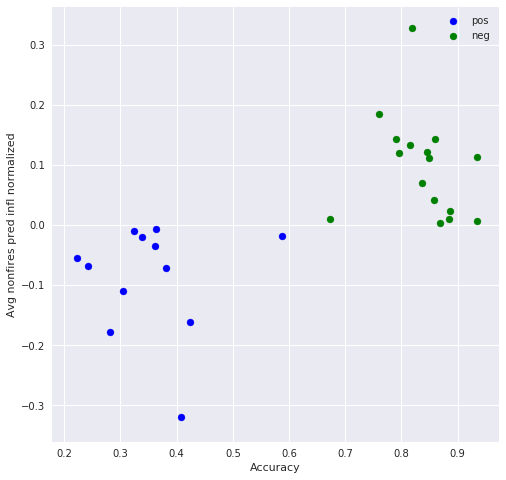

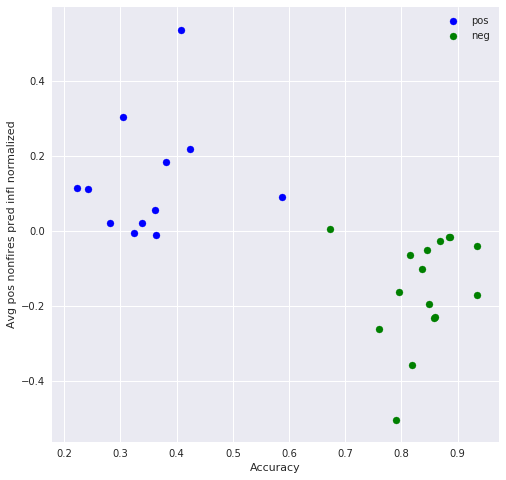

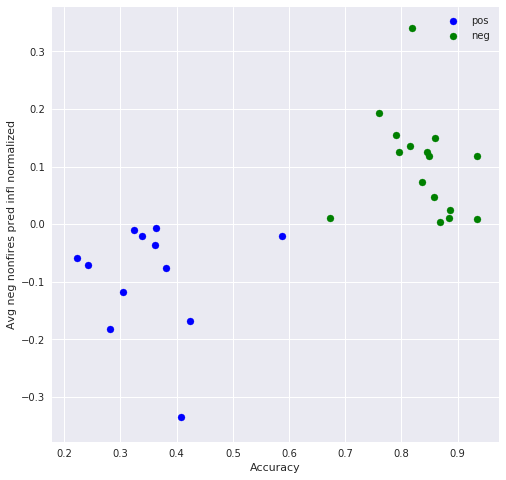

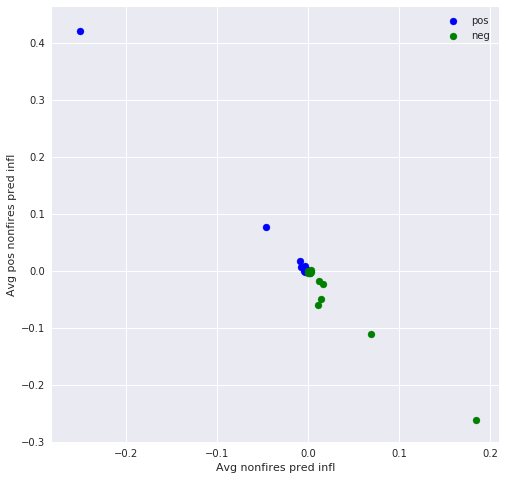

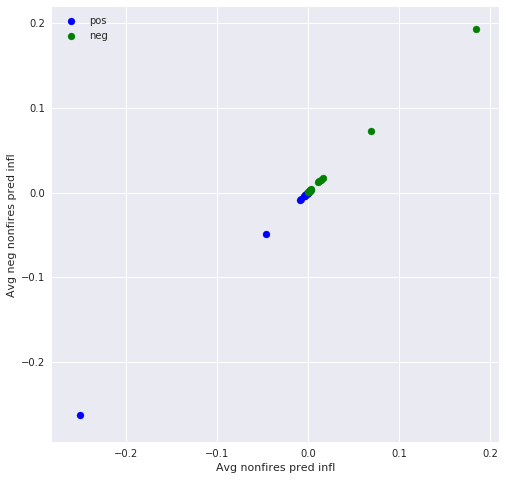

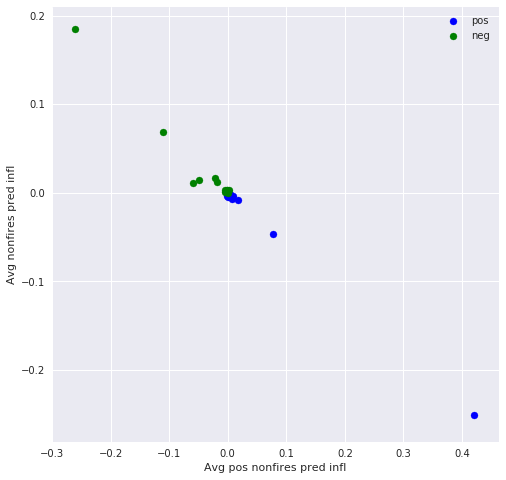

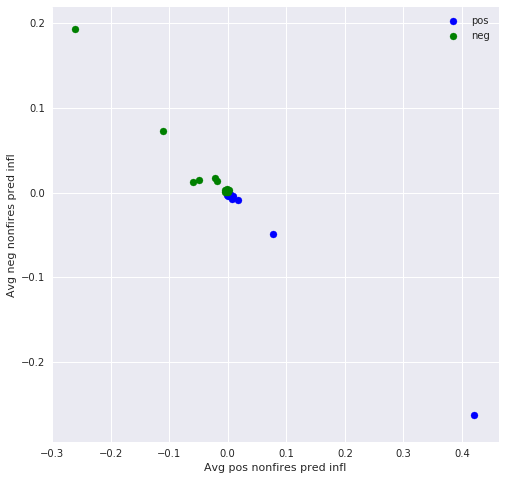

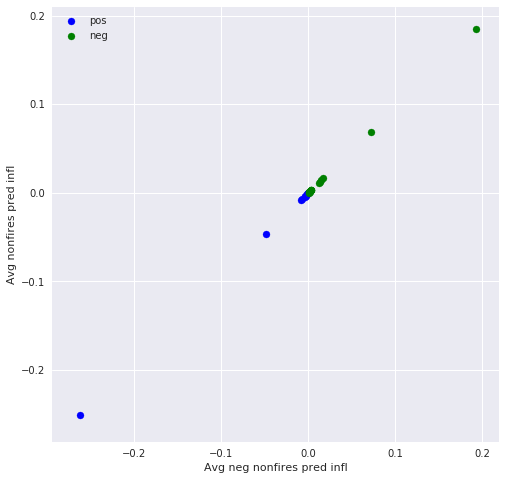

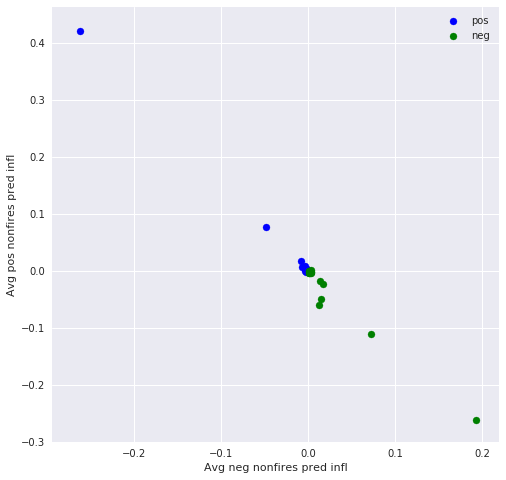

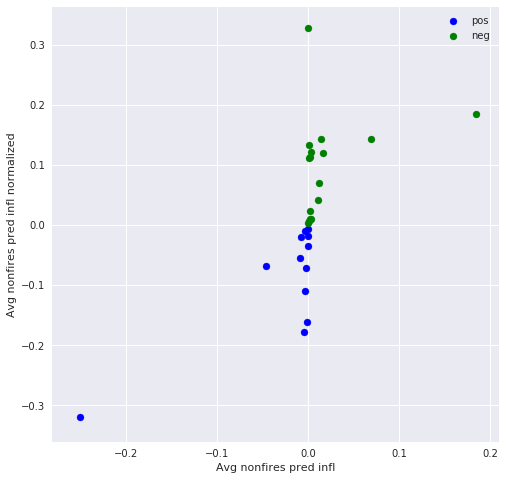

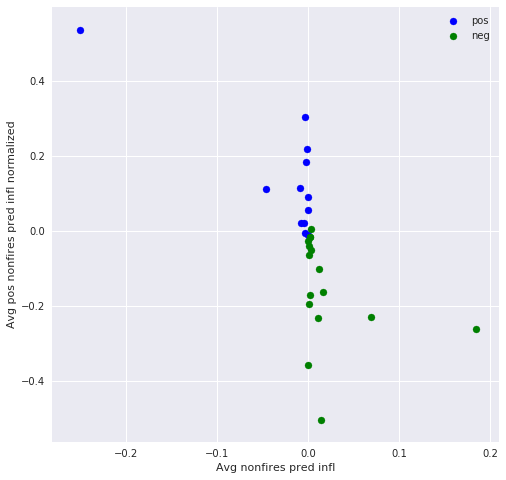

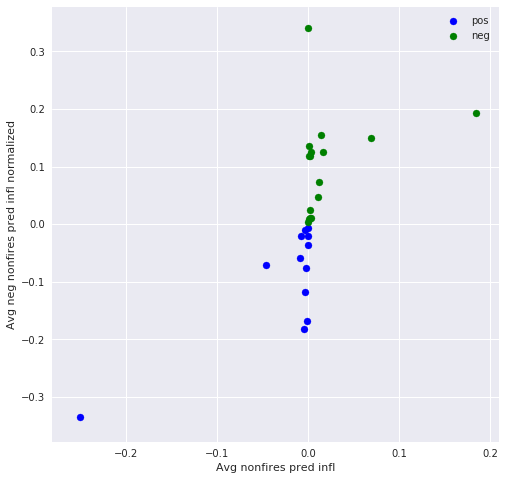

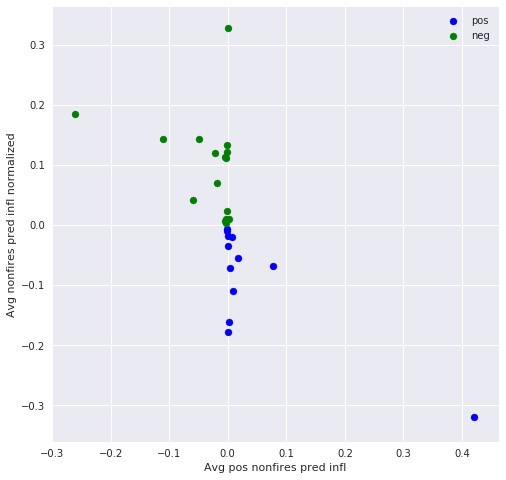

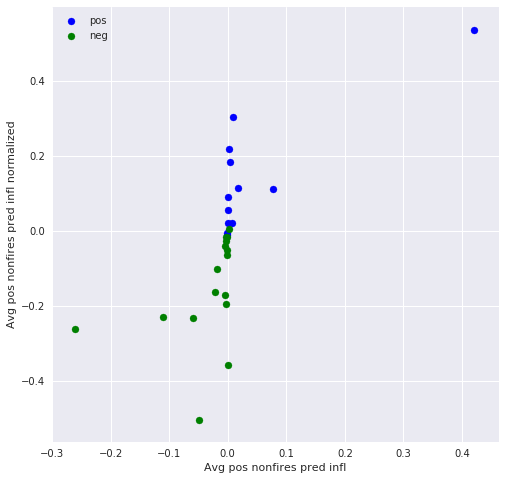

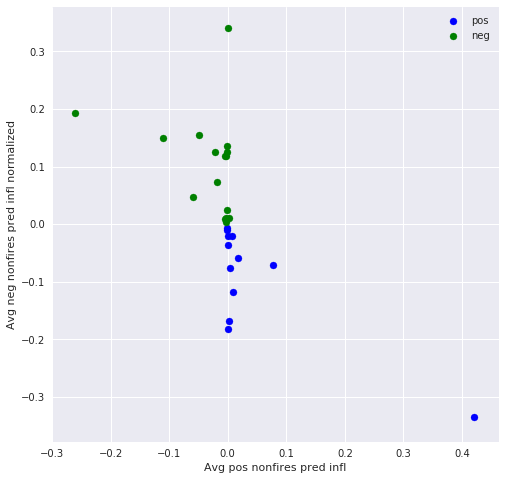

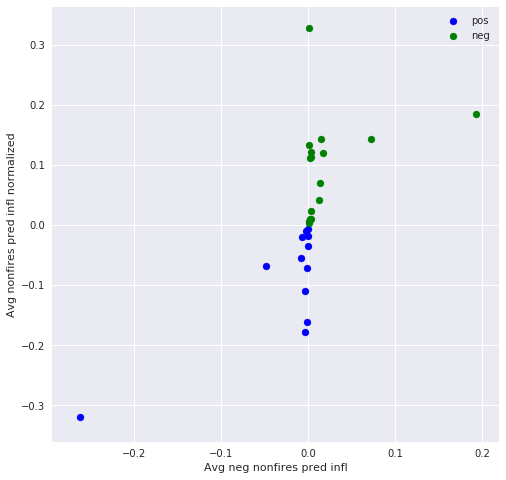

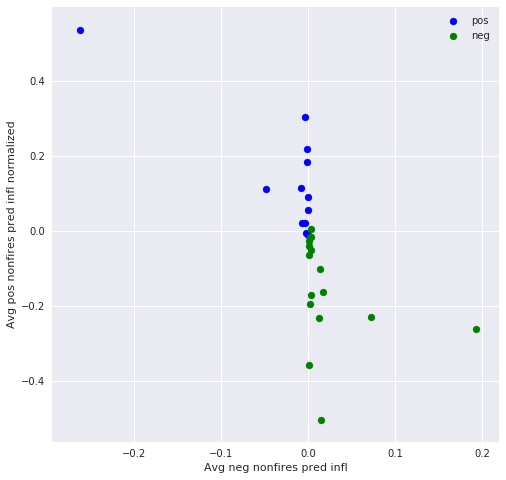

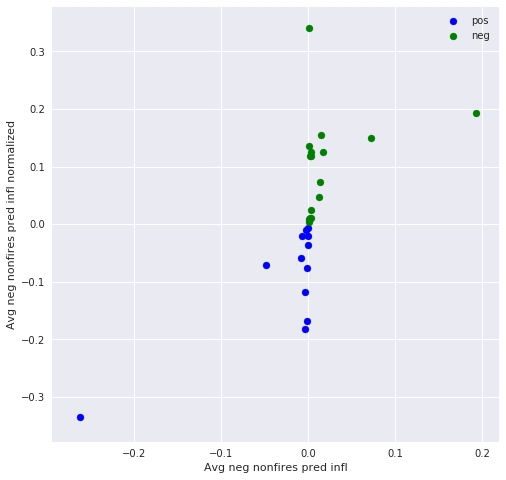

In [4]:
"""for x, x_name in zip(meta, meta_names):
    for y, y_name in zip(infls, infls_names):
        printR(x, y, x_name, y_name)
        if np.abs(calcR(x, y)) > 0.4:
            fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
            scatter(ax[0][0], x, y, class_pos, class_neg, x_name, y_name)
line()
for x, x_name in zip(meta, meta_names):
    for y, y_name in zip(normalized_infls, normalized_infls_names):
        printR(x, y, x_name, y_name)
        if np.abs(calcR(x, y)) > 0.4:
            fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
            scatter(ax[0][0], x, y, class_pos, class_neg, x_name, y_name)
line()
for x, x_name in zip(infls, infls_names):
    for y, y_name in zip(infls, infls_names):
        if x_name != y_name:
            printR(x, y, x_name, y_name)
            if np.abs(calcR(x, y)) > 0.4:
                fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
                scatter(ax[0][0], x, y, class_pos, class_neg, x_name, y_name)
line()
for x, x_name in zip(infls, infls_names):
    for y, y_name in zip(normalized_infls, normalized_infls_names):
        if x_name != y_name:
            printR(x, y, x_name, y_name)
            if np.abs(calcR(x, y)) > 0.4:
                fig, ax = plt.subplots(1,1,figsize=(8,8),squeeze=False)
                scatter(ax[0][0], x, y, class_pos, class_neg, x_name, y_name)
line()
printR(meta[0], meta[1], meta_names[0], meta_names[1])"""

In [79]:
plt.close('all')